# Positional Embeddings: Building Intuition from First Principles

The standard sinusoidal positional embedding formula looks like this:

$$PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{2i/d}}\right)$$
$$PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{2i/d}}\right)$$

**This is confusing.** Why sine and cosine? Why 10000? Why alternate? Why different frequencies?

This notebook will build up to this formula so that by the end, each design choice feels almost *obvious*. We'll start from the fundamental problem and discover each piece through experimentation.


In [286]:
import sys
from pathlib import Path

# Add workspace root to Python path so we can import silen_lib
workspace_root = Path.cwd().parent.parent
if str(workspace_root) not in sys.path:
    sys.path.insert(0, str(workspace_root))

import silen_lib.utils as utils

import numpy as np
import torch
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 4)
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'


## The Problem

A transformer's self-attention treats the input as a **set**, not a sequence. Unlike RNNs, transformers don't have any built-in notion of position (there's no recurrence).

Without positional information:

- "The cat sat on the mat" 
- "The mat sat on the cat"

...would produce **identical** attention patterns. The transformer has no idea which token came first.


In [ ]:
# | toy-attention-original inline expanded
# Toy example: three "tokens" with random embeddings
tokens = np.array([
    [0.5, 0.8],   # token A
    [0.2, 0.9],   # token B  
    [0.7, 0.3],   # token C
])

# Simple attention: how much does each token attend to each other?
# (just dot products, ignoring scaling)
attention = tokens @ tokens.T
print("Attention matrix (no position info):")
print(attention.round(2))


Attention matrix (no position info):
[[0.89 0.82 0.59]
 [0.82 0.85 0.41]
 [0.59 0.41 0.58]]


In [ ]:
# | toy-attention-shuffled inline expanded
# Shuffle the order: C, A, B instead of A, B, C
tokens_shuffled = tokens[[2, 0, 1]]

attention_shuffled = tokens_shuffled @ tokens_shuffled.T
print("Attention after shuffling (C, A, B):")
print(attention_shuffled.round(2))


Attention after shuffling (C, A, B):
[[0.58 0.59 0.41]
 [0.59 0.89 0.82]
 [0.41 0.82 0.85]]


The model can't tell these orderings apart! In other words, the model is equivariant to the order of the tokens.

## Goal: Encode Position

One way that we can do this, is to push the embeddings into a high-dimensional space where each dimension corresponds to a different position.

So all tokens that are the same distance apart in the sequence, are pushed together in the embedding space. And with this, the model can learn to attend to tokens based on their position.

Let's try this out!

## First Attempt

The simplest idea: just use integers as position. Position 0, 1, 2, 3...


In [ ]:
# | example-tensor inline expanded
utils.set_seed(33)
example_tensor = torch.randn(3, 6)
print("Example tensor shape:", example_tensor.shape)
print("Example tensor:", example_tensor)

# these represent three embeddings of tokens 
# for example for seed 42
# "The": [ 1.9269,  1.4873, -0.4974,  0.4396, -0.7581,  1.0783]
# "cat": [ 0.8008,  1.6806,  0.3559, -0.6866,  0.6105,  1.3347]
# "sat":  [-0.2316,  0.0418, -0.2516,  0.8599, -0.3097, -0.3957]

Example tensor shape: torch.Size([3, 6])
Example tensor: tensor([[ 0.6014,  0.1087,  1.2530, -0.6902,  0.2395,  1.3365],
        [-0.5728,  0.5368, -0.8906,  0.9865, -0.3192,  0.3207],
        [-0.1966, -0.7767, -1.4657, -1.0870,  0.3473,  0.9572]])


In [ ]:
# | integer-positions inline expanded
positions = np.arange(example_tensor.shape[0])
print("Position values:", positions)

# Add positions to the example_tensor (broadcasting over columns)
modified_tensor = example_tensor + positions[:, None]
print("Modified example tensor (after adding positions):", modified_tensor)


Position values: [0 1 2]
Modified example tensor (after adding positions): tensor([[ 0.6014,  0.1087,  1.2530, -0.6902,  0.2395,  1.3365],
        [ 0.4272,  1.5368,  0.1094,  1.9865,  0.6808,  1.3207],
        [ 1.8034,  1.2233,  0.5343,  0.9130,  2.3473,  2.9572]],
       dtype=torch.float64)


In [ ]:
# | scale-explosion inline expanded
# Problem 1: Scale explodes with sequence length

# We'll make a large fake embedding tensor: 1000 tokens, each with embedding dim 4
large_tensor = torch.randn(1000, 6)
positions = np.arange(large_tensor.shape[0])

# Add positions to the embeddings (broadcasts over columns)
modified_large_tensor = large_tensor + positions[:, None]

print("Original last 3 embeddings:\n", large_tensor[-3:])
print("Positions of last 3 tokens:", positions[-3:])
print("Modified (with position) last 3 embeddings:\n", modified_large_tensor[-3:])

# See how large these values get!


Original last 3 embeddings:
 tensor([[ 0.7608, -0.1367,  0.9880, -0.4994, -0.0466, -1.3236],
        [ 0.7420,  1.3876,  0.6875,  2.4508, -1.0924,  0.1551],
        [ 0.2145,  0.7141,  0.2667, -2.3133, -0.4357, -0.8918]])
Positions of last 3 tokens: [997 998 999]
Modified (with position) last 3 embeddings:
 tensor([[ 997.7608,  996.8633,  997.9880,  996.5006,  996.9534,  995.6764],
        [ 998.7420,  999.3876,  998.6875, 1000.4508,  996.9076,  998.1551],
        [ 999.2145,  999.7141,  999.2667,  996.6867,  998.5643,  998.1082]],
       dtype=torch.float64)


**Problem**: Token embeddings are typically small values (around -1 to 1). If we add position 9999 directly, the position signal completely drowns out the token meaning (aka semantics).

What if we normalize?


In [ ]:
# | normalized-positions inline
# Attempt 2: Normalize positions to [0, 1] instead of adding large absolute values directly
def normalized_position(pos, max_len):
    return pos / max_len

# This fixes the scale explosion problem, but creates a new problem...
# Let's say our "cat" token appears at position 2 in different length sequences

print("What encoding does 'cat' at position 2 get?")
print()

# In a short sequence (length 6)
seq_len_short = 6
pos_2_short = normalized_position(2, seq_len_short)
print(f"Sequence length 6:  position 2 → {pos_2_short:.3f}")

# In our 3-token sequence
seq_len_medium = 3
pos_2_medium = normalized_position(2, seq_len_medium)
print(f"Sequence length 3:  position 2 → {pos_2_medium:.3f}")

# In a longer sequence (length 100)
seq_len_long = 100
pos_2_long = normalized_position(2, seq_len_long)
print(f"Sequence length 100: position 2 → {pos_2_long:.3f}")

print("\n⚠️ Problem: Position 2 gets DIFFERENT encodings depending on sequence length!")
print("The model can't learn what 'position 2' means - it keeps changing!")
print("\nThis is called SCALE VARIANCE - the encoding depends on the scale (length) of the sequence.")


What encoding does 'cat' at position 2 get?

Sequence length 6:  position 2 → 0.333
Sequence length 3:  position 2 → 0.667
Sequence length 100: position 2 → 0.020

⚠️ Problem: Position 2 gets DIFFERENT encodings depending on sequence length!
The model can't learn what 'position 2' means - it keeps changing!

This is called SCALE VARIANCE - the encoding depends on the scale (length) of the sequence.


### Issues with integer positions:

(a) Scaling creates a dilemma: If we scale positions down to keep values small (e.g., divide by a constant), we get tiny differences at the start of sequences that barely encode position. If we don't scale enough, values blow up for long sequences and drown out the token semantics. We saw this in the first attempt.

(b) Normalization causes scale variance: Normalizing by sequence length (pos/max_len) makes position 5 mean something different in a 10-token sequence (0.5) versus a 100-token sequence (0.05). The model can't learn what "position 5" means because it keeps changing based on sequence length. We saw this in the second attempt.

(c) Raw integers don't generalize: If you train on sequences up to length 100, then try position 150, the model has never seen that value before. It can't extrapolate to unseen position magnitudes.

## What Do We Actually Need?

Let's think about what a good positional encoding needs:

1. **Bounded values** — shouldn't explode for long sequences
2. **Unique per position** — each position needs a distinct encoding
3. **Consistent meaning** — position 5 should mean the same thing regardless of sequence length  
4. **Smooth** — nearby positions should have similar encodings (position 5 and 6 are related)
5. **Learnable relationships** — the model should be able to figure out "token A is 3 positions before token B"

What function is bounded, smooth, and produces unique values? 🤔


## Enter the Sine Function

Sine is bounded between -1 and 1, smooth, and periodic. Let's try using `sin(position)` as our positional encoding!


In [ ]:
# | sin-encoding-basic inline expanded
# Let's use sin(position) to encode position in our embeddings
# Recall our example: "The" (pos 0), "cat" (pos 1), "sat" (pos 2)

positions = np.arange(example_tensor.shape[0])
sin_encoding = np.sin(positions)

print("Position → sin(position):")
for pos, enc in zip(positions, sin_encoding):
    print(f"  Position {pos}: sin({pos}) = {enc:.4f}")

# Add to our example tensor
modified_tensor = example_tensor + sin_encoding[:, None]
print("\nOriginal embeddings:")
print(example_tensor)
print("\nAfter adding sin(position):")
print(modified_tensor)


Position → sin(position):
  Position 0: sin(0) = 0.0000
  Position 1: sin(1) = 0.8415
  Position 2: sin(2) = 0.9093

Original embeddings:
tensor([[ 0.6014,  0.1087,  1.2530, -0.6902,  0.2395,  1.3365],
        [-0.5728,  0.5368, -0.8906,  0.9865, -0.3192,  0.3207],
        [-0.1966, -0.7767, -1.4657, -1.0870,  0.3473,  0.9572]])

After adding sin(position):
tensor([[ 0.6014,  0.1087,  1.2530, -0.6902,  0.2395,  1.3365],
        [ 0.2687,  1.3782, -0.0491,  1.8279,  0.5223,  1.1621],
        [ 0.7127,  0.1326, -0.5564, -0.1777,  1.2566,  1.8665]],
       dtype=torch.float64)


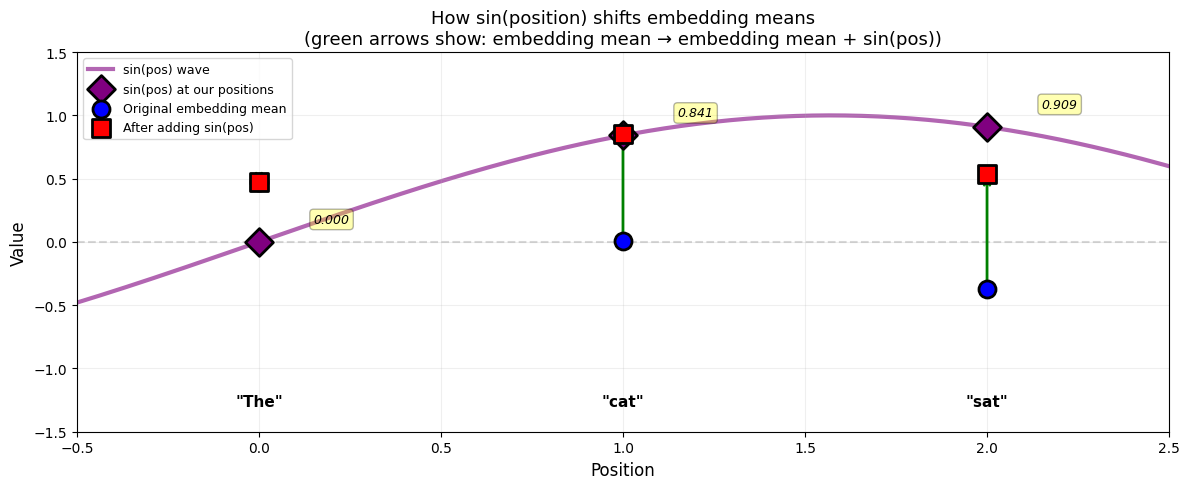

Notice: Each embedding is shifted by exactly sin(position)
The purple wave shows sin(x), and we sample it at positions 0, 1, 2


In [ ]:
# | sin-visualization inline 
# Visualize how sin(position) shifts our embeddings
fig, ax = plt.subplots(figsize=(12, 5))

positions = np.arange(3)
sin_values = np.sin(positions)

# Plot the continuous sin wave prominently
x_smooth = np.linspace(-0.5, 2.5, 200)
ax.plot(x_smooth, np.sin(x_smooth), 'purple', linewidth=3, label='sin(pos) wave', alpha=0.6, zorder=1)

# Mark the discrete sin values at our positions
ax.scatter(positions, sin_values, s=200, marker='D', color='purple', 
           label='sin(pos) at our positions', zorder=4, edgecolors='black', linewidths=2)

# Compute mean of embeddings (represents the "center" of each embedding vector)
original_means = example_tensor.numpy().mean(axis=1)
modified_means = modified_tensor.numpy().mean(axis=1)

# Plot original embedding means
ax.scatter(positions, original_means, s=150, marker='o', color='blue', 
           label='Original embedding mean', zorder=5, edgecolors='black', linewidths=2)

# Plot modified embedding means
ax.scatter(positions, modified_means, s=150, marker='s', color='red', 
           label='After adding sin(pos)', zorder=5, edgecolors='black', linewidths=2)

# Draw arrows showing the shift
for pos in positions:
    ax.annotate('', xy=(pos, modified_means[pos]), xytext=(pos, original_means[pos]),
                arrowprops=dict(arrowstyle='->', lw=2, color='green'))
    # Add sin value text
    ax.text(pos + 0.15, sin_values[pos] + 0.15, f'{sin_values[pos]:.3f}', 
            fontsize=9, style='italic', bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3))

# Mark our tokens
tokens = ["The", "cat", "sat"]
for pos, token in enumerate(tokens):
    ax.text(pos, -1.3, f'"{token}"', fontsize=11, ha='center', weight='bold')

ax.set_xlabel('Position', fontsize=12)
ax.set_ylabel('Value', fontsize=12)
ax.set_title('How sin(position) shifts embedding means\n(green arrows show: embedding mean → embedding mean + sin(pos))', fontsize=13)
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
ax.set_xlim(-0.5, 2.5)
ax.set_ylim(-1.5, 1.5)
ax.legend(loc='upper left', fontsize=9)
ax.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()

print("Notice: Each embedding is shifted by exactly sin(position)")
print("The purple wave shows sin(x), and we sample it at positions 0, 1, 2")

In [ ]:
# | sin-periodicity-problem inline expanded
# Problem: sin repeats every 2π ≈ 6.28 positions!
# Let's see what happens with a longer sequence

positions_long = np.arange(20)
sin_values = np.sin(positions_long)

print("Position → sin(position):")
for pos, val in zip(positions_long, sin_values):
    print(f"  Position {pos}: sin({pos}) = {val:+.4f}")
    
print(f"\n⚠️ Notice: sin(8) = {np.sin(8):.4f} and sin(14) = {np.sin(14):.4f}")
print(f"   They're almost the same! (difference: {abs(np.sin(8) - np.sin(14)):.4f})")


Position → sin(position):
  Position 0: sin(0) = +0.0000
  Position 1: sin(1) = +0.8415
  Position 2: sin(2) = +0.9093
  Position 3: sin(3) = +0.1411
  Position 4: sin(4) = -0.7568
  Position 5: sin(5) = -0.9589
  Position 6: sin(6) = -0.2794
  Position 7: sin(7) = +0.6570
  Position 8: sin(8) = +0.9894
  Position 9: sin(9) = +0.4121
  Position 10: sin(10) = -0.5440
  Position 11: sin(11) = -1.0000
  Position 12: sin(12) = -0.5366
  Position 13: sin(13) = +0.4202
  Position 14: sin(14) = +0.9906
  Position 15: sin(15) = +0.6503
  Position 16: sin(16) = -0.2879
  Position 17: sin(17) = -0.9614
  Position 18: sin(18) = -0.7510
  Position 19: sin(19) = +0.1499

⚠️ Notice: sin(8) = 0.9894 and sin(14) = 0.9906
   They're almost the same! (difference: 0.0012)


**The Problem**: Since sine is periodic, many positions get nearly identical encodings! If we have a 7+ token sequence, the model can't distinguish between the 1st and 7th tokens for example because sine has a fixed period of 2π ≈ 6.28. And as shown above, it gets even worse for longer sequences.

We need a way to control this.

## Adjusting the sine wave

We can stretch or compress the sine wave by multiplying position by a frequency term ω (omega):

$$\sin(\omega \cdot pos)$$

- Higher ω = faster oscillation (repeats more quickly)
- Lower ω = slower oscillation (takes longer to repeat)


In [ ]:
# | frequency-stretch inline expanded
# Let's try a lower frequency: ω = 0.1
# This means sin(0.1 * position) - the wave stretches out

freq_low = 0.1
positions = np.arange(15)

print(f"With ω = {freq_low}:")
print("Position → sin(ω × position):")
for pos in positions:
    val = np.sin(freq_low * pos)
    print(f"  Position {pos}: sin({freq_low} × {pos}) = sin({freq_low * pos:.1f}) = {val:+.4f}")

print(f"\n✓ Now position 8 and position 14 are different!")
print(f"  sin(0.1 × 8) = {np.sin(freq_low * 8):.4f}")
print(f"  sin(0.1 × 14) = {np.sin(freq_low * 14):.4f}")


With ω = 0.1:
Position → sin(ω × position):
  Position 0: sin(0.1 × 0) = sin(0.0) = +0.0000
  Position 1: sin(0.1 × 1) = sin(0.1) = +0.0998
  Position 2: sin(0.1 × 2) = sin(0.2) = +0.1987
  Position 3: sin(0.1 × 3) = sin(0.3) = +0.2955
  Position 4: sin(0.1 × 4) = sin(0.4) = +0.3894
  Position 5: sin(0.1 × 5) = sin(0.5) = +0.4794
  Position 6: sin(0.1 × 6) = sin(0.6) = +0.5646
  Position 7: sin(0.1 × 7) = sin(0.7) = +0.6442
  Position 8: sin(0.1 × 8) = sin(0.8) = +0.7174
  Position 9: sin(0.1 × 9) = sin(0.9) = +0.7833
  Position 10: sin(0.1 × 10) = sin(1.0) = +0.8415
  Position 11: sin(0.1 × 11) = sin(1.1) = +0.8912
  Position 12: sin(0.1 × 12) = sin(1.2) = +0.9320
  Position 13: sin(0.1 × 13) = sin(1.3) = +0.9636
  Position 14: sin(0.1 × 14) = sin(1.4) = +0.9854

✓ Now position 8 and position 14 are different!
  sin(0.1 × 8) = 0.7174
  sin(0.1 × 14) = 0.9854


In [ ]:
# | frequency-tradeoff inline expanded
# But wait - there's a tradeoff!
# With low frequency, NEARBY positions become hard to distinguish

freq_high = 1.0
freq_low = 0.1

print("THE TRADEOFF:")
print("\nHigh frequency (ω=1.0) - good for nearby, bad for far:")
print(f"  Position 0 vs 1: |{np.sin(freq_high * 0):.4f} - {np.sin(freq_high * 1):.4f}| = {abs(np.sin(freq_high * 0) - np.sin(freq_high * 1)):.4f} ✓ different")
print(f"  Position 0 vs 6: |{np.sin(freq_high * 0):.4f} - {np.sin(freq_high * 6):.4f}| = {abs(np.sin(freq_high * 0) - np.sin(freq_high * 6)):.4f} ✗ too similar!")

print("\nLow frequency (ω=0.1) - good for far, bad for nearby:")
print(f"  Position 0 vs 1: |{np.sin(freq_low * 0):.4f} - {np.sin(freq_low * 1):.4f}| = {abs(np.sin(freq_low * 0) - np.sin(freq_low * 1)):.4f} ✗ too similar!")
print(f"  Position 0 vs 6: |{np.sin(freq_low * 0):.4f} - {np.sin(freq_low * 6):.4f}| = {abs(np.sin(freq_low * 0) - np.sin(freq_low * 6)):.4f} ✓ different")

print("\n→ We can't win with a single frequency!")


THE TRADEOFF:

High frequency (ω=1.0) - good for nearby, bad for far:
  Position 0 vs 1: |0.0000 - 0.8415| = 0.8415 ✓ different
  Position 0 vs 6: |0.0000 - -0.2794| = 0.2794 ✗ too similar!

Low frequency (ω=0.1) - good for far, bad for nearby:
  Position 0 vs 1: |0.0000 - 0.0998| = 0.0998 ✗ too similar!
  Position 0 vs 6: |0.0000 - 0.5646| = 0.5646 ✓ different

→ We can't win with a single frequency!


## The Key Insight Multiple Dimensions

What if instead of using a single frequency number for the position encoding that we broadcast to all weights in the embedding matrix, we use multiple dimensions to encode what it means to be in a certain position?

**Solution**: Use MULTIPLE dimensions, each with a DIFFERENT frequency!

- High frequency dimension → distinguishes nearby positions  
- Low frequency dimension → distinguishes far positions

Together, they give us the best of both worlds.

In [ ]:
# | two-freq-encoding inline expanded
# Let's encode each position with TWO dimensions: one high freq, one low freq
freq_high = 1.0
freq_low = 0.1

print("Two-dimensional encoding for positions 0-20:")
print("pos | sin(1.0×pos) | sin(0.1×pos)")
print("-" * 40)
for pos in range(21):
    high = np.sin(freq_high * pos)
    low = np.sin(freq_low * pos)
    print(f"  {pos} |    {high:+.4f}   |    {low:+.4f}")

print("\nNow position 8 and 14 are distinguishable!")
print(f"  pos 8:  ({np.sin(freq_high * 8):+.4f}, {np.sin(freq_low * 8):+.4f})")
print(f"  pos 14: ({np.sin(freq_high * 14):+.4f}, {np.sin(freq_low * 14):+.4f})")


Two-dimensional encoding for positions 0-20:
pos | sin(1.0×pos) | sin(0.1×pos)
----------------------------------------
  0 |    +0.0000   |    +0.0000
  1 |    +0.8415   |    +0.0998
  2 |    +0.9093   |    +0.1987
  3 |    +0.1411   |    +0.2955
  4 |    -0.7568   |    +0.3894
  5 |    -0.9589   |    +0.4794
  6 |    -0.2794   |    +0.5646
  7 |    +0.6570   |    +0.6442
  8 |    +0.9894   |    +0.7174
  9 |    +0.4121   |    +0.7833
  10 |    -0.5440   |    +0.8415
  11 |    -1.0000   |    +0.8912
  12 |    -0.5366   |    +0.9320
  13 |    +0.4202   |    +0.9636
  14 |    +0.9906   |    +0.9854
  15 |    +0.6503   |    +0.9975
  16 |    -0.2879   |    +0.9996
  17 |    -0.9614   |    +0.9917
  18 |    -0.7510   |    +0.9738
  19 |    +0.1499   |    +0.9463
  20 |    +0.9129   |    +0.9093

Now position 8 and 14 are distinguishable!
  pos 8:  (+0.9894, +0.7174)
  pos 14: (+0.9906, +0.9854)


In [ ]:
# | two-freq-applied inline expanded
# Let's apply this to our actual embeddings
# Our example_tensor has 5 dimensions, so let's use 2 frequencies (4 dims for sin/cos pairs + 1 extra)

frequencies = [1.0, 0.1]  # high and low frequency

# For our 3 tokens: "The" (pos 0), "cat" (pos 1), "sat" (pos 2)
print("Multi-frequency positional encoding for our 3 tokens:")
print("Token   | pos | high freq   | low freq")
print("-" * 50)

tokens = ["The", "cat", "sat"]
for pos, token in enumerate(tokens):
    high = np.sin(frequencies[0] * pos)
    low = np.sin(frequencies[1] * pos)
    print(f"{token:7} |  {pos}  | sin({frequencies[0]}×{pos})={high:+.3f} | sin({frequencies[1]}×{pos})={low:+.3f}")


Multi-frequency positional encoding for our 3 tokens:
Token   | pos | high freq   | low freq
--------------------------------------------------
The     |  0  | sin(1.0×0)=+0.000 | sin(0.1×0)=+0.000
cat     |  1  | sin(1.0×1)=+0.841 | sin(0.1×1)=+0.100
sat     |  2  | sin(1.0×2)=+0.909 | sin(0.1×2)=+0.199


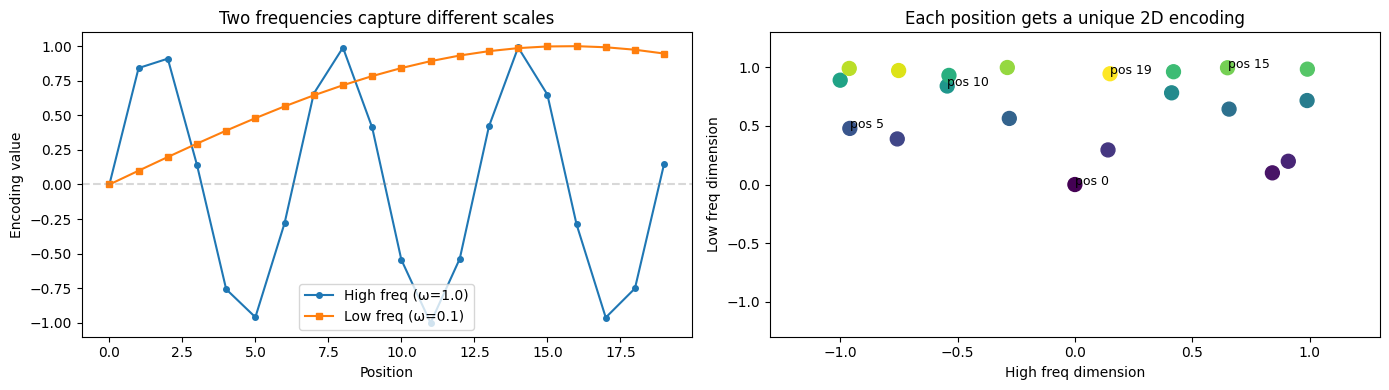

In [ ]:
# | two-freq-visualization inline
# Visualize the two-frequency encoding
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

positions = np.arange(20)

# Left: show both frequencies over position
ax1.plot(positions, np.sin(1.0 * positions), 'o-', label='High freq (ω=1.0)', markersize=4)
ax1.plot(positions, np.sin(0.1 * positions), 's-', label='Low freq (ω=0.1)', markersize=4)
ax1.set_xlabel('Position')
ax1.set_ylabel('Encoding value')
ax1.set_title('Two frequencies capture different scales')
ax1.legend()
ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.3)

# Right: show as 2D points
ax2.scatter([np.sin(1.0 * p) for p in positions], 
           [np.sin(0.1 * p) for p in positions], 
           c=positions, cmap='viridis', s=100)
for p in [0, 5, 10, 15, 19]:
    ax2.annotate(f'pos {p}', (np.sin(1.0 * p), np.sin(0.1 * p)), 
                fontsize=9, ha='left')
ax2.set_xlabel('High freq dimension')
ax2.set_ylabel('Low freq dimension')
ax2.set_title('Each position gets a unique 2D encoding')
ax2.set_xlim(-1.3, 1.3)
ax2.set_ylim(-1.3, 1.3)

plt.tight_layout()
plt.show()


This is great and solves most of our problems! 

But we can do better. 

There's a way we can make position encodings that are even more unique and learnable while maintaining the same properties of this sine wave.

## Solution: Add Cosine

There's another trick: for each frequency, we can use **both sine and cosine**

The problem is that sine alone can still be ambiguous. And at times we can still have similar values for different positions.

**Solution**: Add cosine! Since cosine is phase-shifted by π/2 from sine, when two positions have the same sine value, they'll have DIFFERENT cosine values.

Cosine is just sine shifted by π/2 (90°). Using both gives us two orthogonal (independent) signals at each frequency.


In [ ]:
# | sin-cos-ambiguity inline expanded
freq = 1.0

print("Adding cosine resolves the ambiguity!\n")
print("pos | sin(pos) | cos(pos) | (sin, cos) pair")
print("-" * 50)

ambiguous_positions = [0, 6, 8, 14]
for pos in ambiguous_positions:
    s = np.sin(freq * pos)
    c = np.cos(freq * pos)
    print(f" {pos:2} |  {s:+.4f}  |  {c:+.4f}  | ({s:+.4f}, {c:+.4f})")

print("\n✓ Cosine adds further uniqueness!")


Adding cosine resolves the ambiguity!

pos | sin(pos) | cos(pos) | (sin, cos) pair
--------------------------------------------------
  0 |  +0.0000  |  +1.0000  | (+0.0000, +1.0000)
  6 |  -0.2794  |  +0.9602  | (-0.2794, +0.9602)
  8 |  +0.9894  |  -0.1455  | (+0.9894, -0.1455)
 14 |  +0.9906  |  +0.1367  | (+0.9906, +0.1367)

✓ Cosine adds further uniqueness!


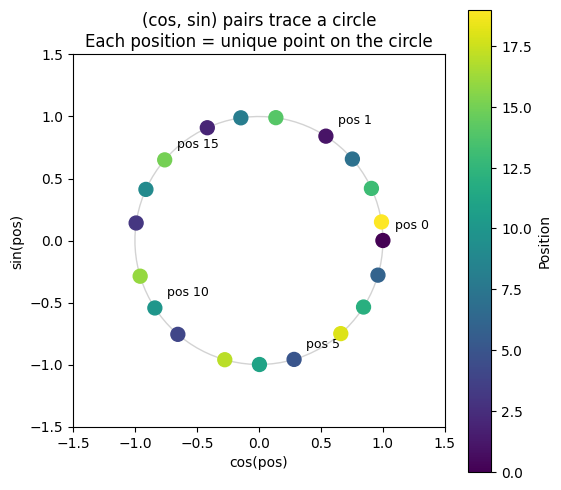

In [ ]:
# | circle-visualization inline
# Visualize: (sin, cos) traces out a circle as position increases
fig, ax = plt.subplots(figsize=(6, 6))

positions = np.arange(20)
sin_vals = np.sin(positions)
cos_vals = np.cos(positions)

# Draw the unit circle
theta = np.linspace(0, 2*np.pi, 100)
ax.plot(np.cos(theta), np.sin(theta), 'lightgray', linewidth=1)

# Plot position points
scatter = ax.scatter(cos_vals, sin_vals, c=positions, cmap='viridis', s=100, zorder=5)
for pos in [0, 1, 5, 10, 15]:
    ax.annotate(f'pos {pos}', (cos_vals[pos]+0.1, sin_vals[pos]+0.1), fontsize=9)

ax.set_xlabel('cos(pos)')
ax.set_ylabel('sin(pos)')
ax.set_title('(cos, sin) pairs trace a circle\nEach position = unique point on the circle')
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_aspect('equal')
plt.colorbar(scatter, label='Position')
plt.show()


Positional encodings (2 frequencies × 2 for sin/cos = 4 dimensions):
[[ 0.     1.     0.     1.   ]
 [ 0.841  0.54   0.1    0.995]
 [ 0.909 -0.416  0.199  0.98 ]]


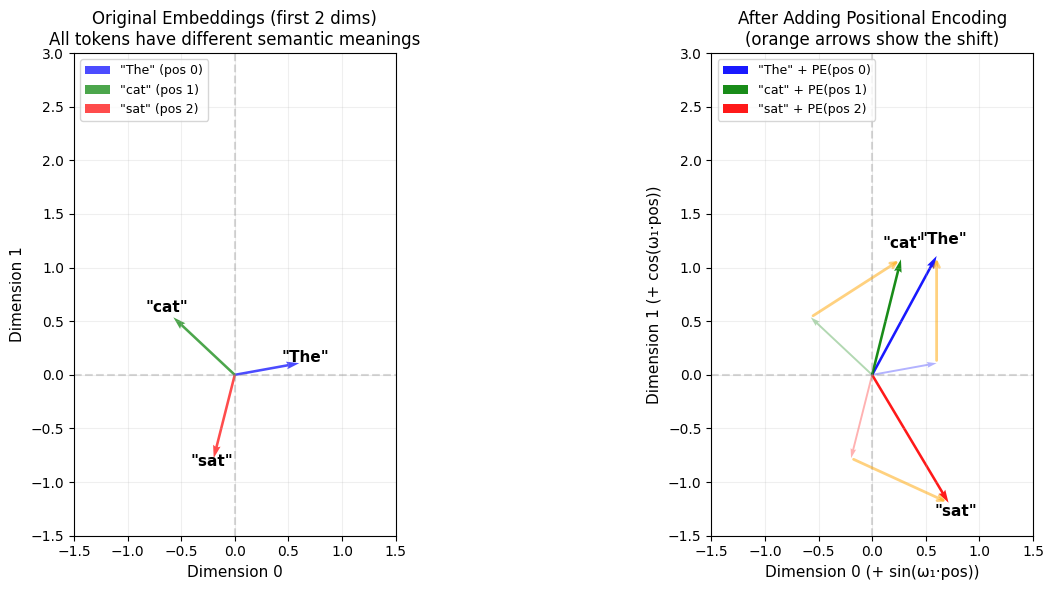

In [ ]:
# | sin-cos-embedding-viz inline 
# Visualize how (sin, cos) positional encoding shifts our embeddings
# We'll use 2 frequencies, giving us 4 dimensions of positional info

# Create a simple 2-frequency positional encoding for our 3 tokens
frequencies = [1.0, 0.1]
pe_2freq = np.zeros((3, 4))

for pos in range(3):
    for i, freq in enumerate(frequencies):
        pe_2freq[pos, 2*i] = np.sin(freq * pos)  # sin
        pe_2freq[pos, 2*i+1] = np.cos(freq * pos)  # cos

print("Positional encodings (2 frequencies × 2 for sin/cos = 4 dimensions):")
print(pe_2freq.round(3))

# Add positional encoding to first 4 dimensions of our embeddings
original_vecs = example_tensor.numpy()[:, :2]  
modified_vecs = original_vecs + pe_2freq[:, :2]
# for the purpose of visualization, we only use the first 2 dimensions

# Plot as 2D vectors
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

tokens = ["The", "cat", "sat"]
colors = ['blue', 'green', 'red']

# Left plot: Original embeddings (first 2 dimensions)
for i, (token, color) in enumerate(zip(tokens, colors)):
    ax1.quiver(0, 0, original_vecs[i, 0], original_vecs[i, 1], 
               angles='xy', scale_units='xy', scale=1, color=color, 
               width=0.008, alpha=0.7, label=f'"{token}" (pos {i})')
    ax1.text(original_vecs[i, 0]*1.1, original_vecs[i, 1]*1.1, f'"{token}"', 
             fontsize=11, weight='bold', ha='center')

ax1.set_xlim(-1.5, 1.5)
ax1.set_ylim(-1.5, 3)
ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
ax1.axvline(x=0, color='gray', linestyle='--', alpha=0.3)
ax1.set_xlabel('Dimension 0', fontsize=11)
ax1.set_ylabel('Dimension 1', fontsize=11)
ax1.set_title('Original Embeddings (first 2 dims)\nAll tokens have different semantic meanings', fontsize=12)
ax1.grid(True, alpha=0.2)
ax1.set_aspect('equal')
ax1.legend(loc='upper left', fontsize=9)

# Right plot: After adding positional encoding
for i, (token, color) in enumerate(zip(tokens, colors)):
    # Show both original and modified
    ax2.quiver(0, 0, original_vecs[i, 0], original_vecs[i, 1], 
               angles='xy', scale_units='xy', scale=1, color=color, 
               width=0.006, alpha=0.3, linestyle='dashed')
    ax2.quiver(0, 0, modified_vecs[i, 0], modified_vecs[i, 1], 
               angles='xy', scale_units='xy', scale=1, color=color, 
               width=0.008, alpha=0.9, label=f'"{token}" + PE(pos {i})')
    
    # Arrow showing the shift
    ax2.annotate('', xy=(modified_vecs[i, 0], modified_vecs[i, 1]), 
                 xytext=(original_vecs[i, 0], original_vecs[i, 1]),
                 arrowprops=dict(arrowstyle='->', lw=2, color='orange', alpha=0.5))
    
    ax2.text(modified_vecs[i, 0]*1.1, modified_vecs[i, 1]*1.1, f'"{token}"', 
             fontsize=11, weight='bold', ha='center')

ax2.set_xlim(-1.5, 1.5)
ax2.set_ylim(-1.5, 3)
ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
ax2.axvline(x=0, color='gray', linestyle='--', alpha=0.3)
ax2.set_xlabel('Dimension 0 (+ sin(ω₁·pos))', fontsize=11)
ax2.set_ylabel('Dimension 1 (+ cos(ω₁·pos))', fontsize=11)
ax2.set_title('After Adding Positional Encoding\n(orange arrows show the shift)', fontsize=12)
ax2.grid(True, alpha=0.2)
ax2.set_aspect('equal')
ax2.legend(loc='upper left', fontsize=9)

plt.tight_layout()
plt.show()

## The Frequency Formula — Where Does 10000 Come From?

So far we've picked frequencies like 1.0 and 0.1 arbitrarily. The original Transformer paper uses a specific formula:

$$\omega_i = \frac{1}{10000^{2i/d}}$$

where:
- `i` = which frequency we're computing (0, 1, 2, ...) which is related to the position in embedding matrix to encode more uniqueness per dimension. For both cos and sin, the frequency is the same for each pair. So dimensions 0 and 1 have the same frequency but are sin and cos respectively. Etc.
- `d` = total embedding dimension

Let's see what frequencies this gives us.


In [ ]:
# | frequency-formula inline expanded
# Let's compute frequencies for a small embedding dimension
d = 10  # embedding dimension (our example_tensor has d=5, but 6 is easier to demonstrate)

print(f"For d={d}, we have {d//2} frequency pairs (sin/cos):\n")
print("-" * 60)
print("x | i: {2*i},{2*i+1} |   2i/d   |    10000^(2i/d)   | ω = 1/10000^(2i/d) | sin, cos(ω*x)")
print(f"pos |  i: dims  |     exponent     |  base power  |      freq      |    sin,cos(freq*pos)")
for x in range(2): # the 2 vectors
    for i in range(d // 2): # dimensions of the vector
        exponent = 2 * i / d
        base_power = 10000 ** exponent
        freq = 1 / base_power
        pos_freq = x * freq
        cos_pos_freq = np.cos(pos_freq)
        sin_pos_freq = np.sin(pos_freq)
        print(f"{x}   |   {i}: {2*i},{2*i+1} |       {exponent:.3f}      |   {base_power:>10.2f} |     {freq:.6f}    |    {sin_pos_freq}, {cos_pos_freq:.6f}")


For d=10, we have 5 frequency pairs (sin/cos):

------------------------------------------------------------
x | i: {2*i},{2*i+1} |   2i/d   |    10000^(2i/d)   | ω = 1/10000^(2i/d) | sin, cos(ω*x)
pos |  i: dims  |     exponent     |  base power  |      freq      |    sin,cos(freq*pos)
0   |   0: 0,1 |       0.000      |         1.00 |     1.000000    |    0.0, 1.000000
0   |   1: 2,3 |       0.200      |         6.31 |     0.158489    |    0.0, 1.000000
0   |   2: 4,5 |       0.400      |        39.81 |     0.025119    |    0.0, 1.000000
0   |   3: 6,7 |       0.600      |       251.19 |     0.003981    |    0.0, 1.000000
0   |   4: 8,9 |       0.800      |      1584.89 |     0.000631    |    0.0, 1.000000
1   |   0: 0,1 |       0.000      |         1.00 |     1.000000    |    0.8414709848078965, 0.540302
1   |   1: 2,3 |       0.200      |         6.31 |     0.158489    |    0.1578266401303058, 0.987467
1   |   2: 4,5 |       0.400      |        39.81 |     0.025119    |    0.025116

**Key insight**: The frequencies form a geometric progression:
- i=0 gives ω=1 (high frequency, repeats every ~6 positions)  
- i=d/2-1 gives ω≈1/10000 (very low frequency, wavelength ~63,000 positions)

**Why 10000?** It ensures we can handle sequences up to ~10,000 tokens without the lowest frequency repeating. This is why it's called a "base" — it sets the maximum context length.


### Understanding the Low Frequency Dimensions

Notice in the encoding above: the last few dimensions (low frequency) barely change between positions 0, 1, and 2. This is the tradeoff we discussed earlier — but now we have high frequency dimensions to compensate!


In [ ]:
# | high-low-freq-comparison inline expanded
# Show explicitly: high freq dimensions change a lot, low freq barely changes
d = 8
i_values = np.arange(d // 2)
frequencies = 1 / (10000 ** (2 * i_values / d))

print("Change in encoding from position 0 → position 1:")
print()
for i, freq in enumerate(frequencies):
    diff_sin = abs(np.sin(freq * 1) - np.sin(freq * 0))
    diff_cos = abs(np.cos(freq * 1) - np.cos(freq * 0))
    print(f"Frequency {i} (ω={freq:.6f}): sin Δ = {diff_sin:.6f}, cos Δ = {diff_cos:.6f}")
    
print("\n→ High frequencies (top) capture fine position differences")
print("→ Low frequencies (bottom) capture coarse/global position")


Change in encoding from position 0 → position 1:

Frequency 0 (ω=1.000000): sin Δ = 0.841471, cos Δ = 0.459698
Frequency 1 (ω=0.100000): sin Δ = 0.099833, cos Δ = 0.004996
Frequency 2 (ω=0.010000): sin Δ = 0.010000, cos Δ = 0.000050
Frequency 3 (ω=0.001000): sin Δ = 0.001000, cos Δ = 0.000000

→ High frequencies (top) capture fine position differences
→ Low frequencies (bottom) capture coarse/global position


## Putting It All Together

Now we have all the pieces. The full formula:

$$PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{2i/d}}\right)$$
$$PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{2i/d}}\right)$$

Let's build a function that computes this and apply it to our example.


In [306]:
# | pe-function inline expanded
def positional_encoding(max_len, d_model):
    """
    Generate sinusoidal positional encodings.
    
    Args:
        max_len: maximum sequence length
        d_model: embedding dimension (must be even)
    
    Returns:
        (max_len, d_model) array of positional encodings
    """
    positions = np.arange(max_len)[:, np.newaxis]  # (max_len, 1)
    i = np.arange(d_model // 2)[np.newaxis, :]     # (1, d_model/2)
    
    # Frequency for each dimension: 1 / 10000^(2i/d)
    frequencies = 1 / (10000 ** (2 * i / d_model))
    
    # Compute angles: position × frequency
    angles = positions * frequencies  # (max_len, d_model/2)
    
    # Interleave sin and cos: [sin0, cos0, sin1, cos1, ...]
    pe = np.zeros((max_len, d_model))
    pe[:, 0::2] = np.sin(angles)  # even indices
    pe[:, 1::2] = np.cos(angles)  # odd indices
    
    return pe


In [ ]:
# | pe-added-to-embeddings inline expanded
# Now let's add this to actual token embeddings!
# We'll use a tensor with d=6 to match our positional encoding
print("Original token embeddings:")
token_embeddings = example_tensor
print(token_embeddings)

print("\nPositional encodings (what we add):")
print(pe)

# Add them together
combined = example_tensor.numpy() + pe
print("\nToken embeddings + positional encoding:")
print(combined.round(4))


Original token embeddings:
tensor([[ 0.6014,  0.1087,  1.2530, -0.6902,  0.2395,  1.3365],
        [-0.5728,  0.5368, -0.8906,  0.9865, -0.3192,  0.3207],
        [-0.1966, -0.7767, -1.4657, -1.0870,  0.3473,  0.9572]])

Positional encodings (what we add):
[[ 0.          1.          0.          1.          0.          1.        ]
 [ 0.84147098  0.54030231  0.04639922  0.99892298  0.00215443  0.99999768]
 [ 0.90929743 -0.41614684  0.0926985   0.99569422  0.00430886  0.99999072]]

Token embeddings + positional encoding:
[[ 0.6014  1.1087  1.253   0.3098  0.2395  2.3365]
 [ 0.2687  1.0771 -0.8442  1.9854 -0.317   1.3207]
 [ 0.7127 -1.1929 -1.373  -0.0913  0.3516  1.9572]]


In [ ]:
# | same-token-diff-positions inline
# Key point: same token at different positions now has different representations!
# If we had "The" at position 0 vs position 5:

pe_long = positional_encoding(max_len=10, d_model=6)

the_embedding = token_embeddings[0].numpy()  # "The" token embedding

the_at_pos_0 = the_embedding + pe_long[0]
the_at_pos_5 = the_embedding + pe_long[5]

print('"The" at position 0:', the_at_pos_0.round(4))
print('"The" at position 5:', the_at_pos_5.round(4))
print('\nDifference:', (the_at_pos_5 - the_at_pos_0).round(4))
print("→ Same token, but model sees different vectors based on position!")


"The" at position 0: [0.6014 1.1087 1.253  0.3098 0.2395 2.3365]
"The" at position 5: [-0.3576  0.3924  1.483   0.283   0.2503  2.3365]

Difference: [-9.589e-01 -7.163e-01  2.300e-01 -2.680e-02  1.080e-02 -1.000e-04]
→ Same token, but model sees different vectors based on position!


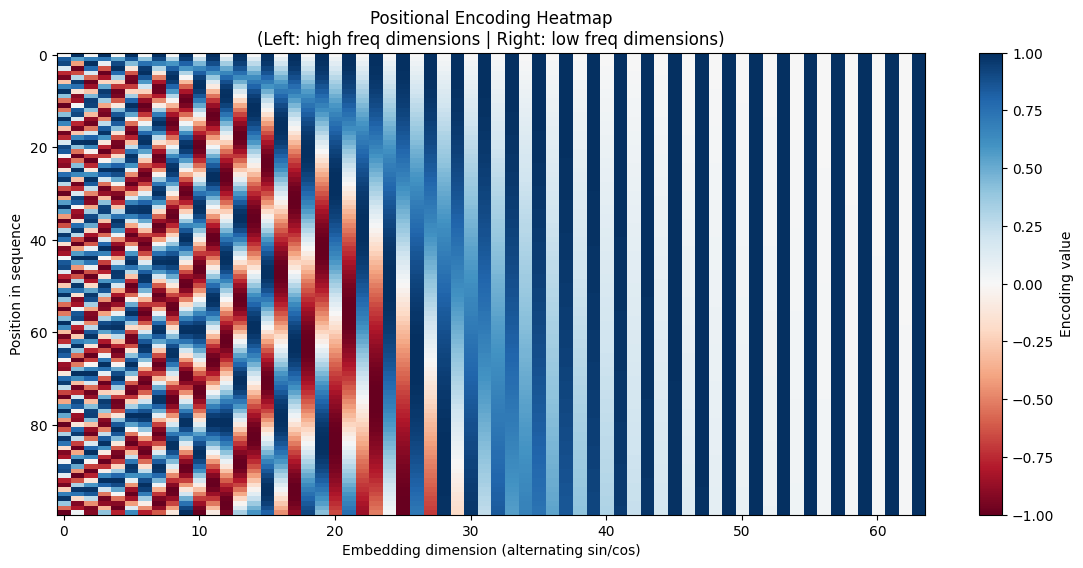

Shape: (100, 64) (100 positions × 64 dimensions)


In [310]:
# | pe-matrix-heatmap inline
# Visualize the full positional encoding matrix for a longer sequence
pe_vis = positional_encoding(max_len=100, d_model=64)

plt.figure(figsize=(14, 6))
plt.imshow(pe_vis, aspect='auto', cmap='RdBu', vmin=-1, vmax=1)
plt.colorbar(label='Encoding value')
plt.xlabel('Embedding dimension (alternating sin/cos)')
plt.ylabel('Position in sequence')
plt.title('Positional Encoding Heatmap\n(Left: high freq dimensions | Right: low freq dimensions)')
plt.show()

print(f"Shape: {pe_vis.shape} (100 positions × 64 dimensions)")


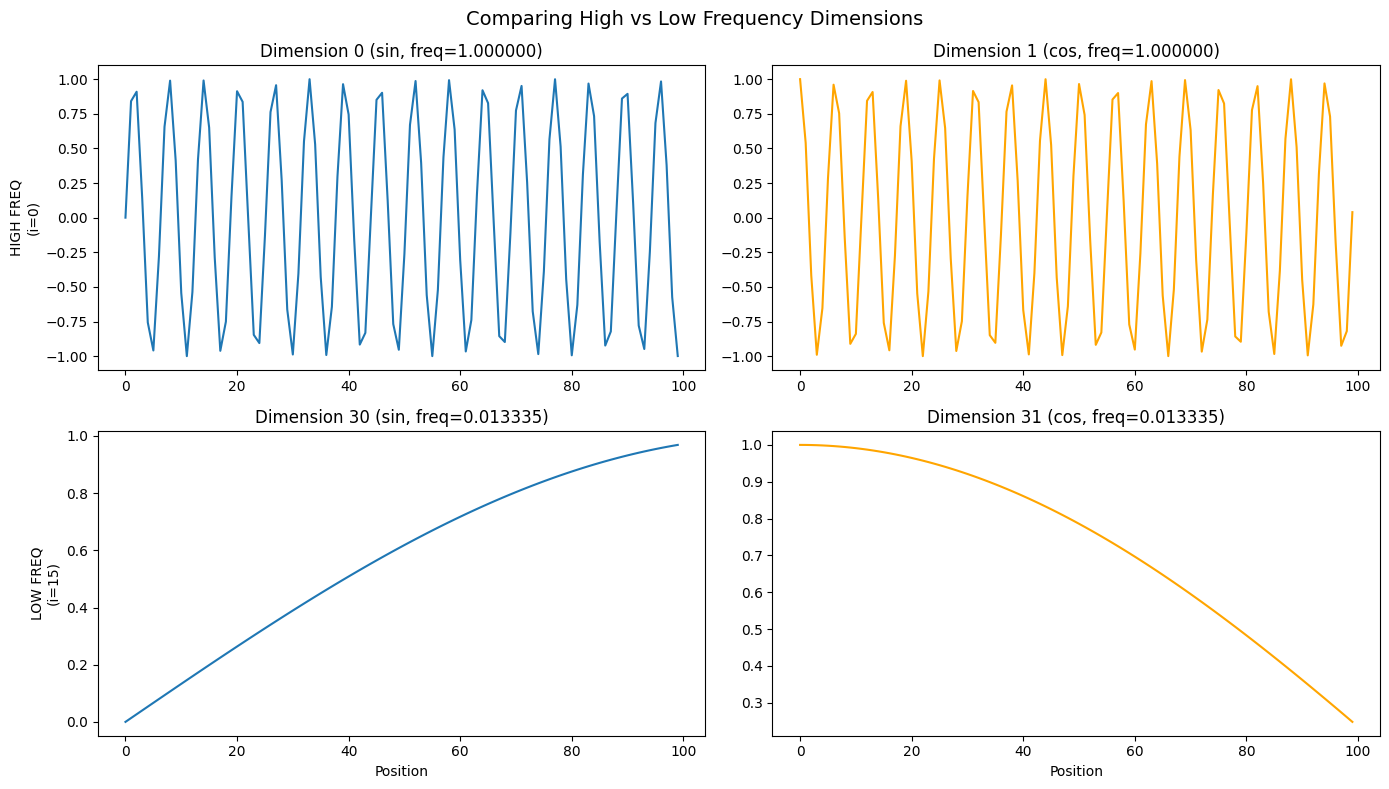

In [311]:
# | pe-dimension-analysis inline
# Look at specific dimensions to see the frequency differences
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

dims_to_show = [(0, 1), (30, 31)]  # high freq pair and low freq pair
pe = pe_vis

for row, (sin_dim, cos_dim) in enumerate(dims_to_show):
    freq_idx = sin_dim // 2
    freq = 1 / (10000 ** (2 * freq_idx / 64))
    
    axes[row, 0].plot(pe[:, sin_dim], linewidth=1.5)
    axes[row, 0].set_title(f'Dimension {sin_dim} (sin, freq={freq:.6f})')
    axes[row, 0].set_ylabel('Encoding value')
    
    axes[row, 1].plot(pe[:, cos_dim], linewidth=1.5, color='orange')
    axes[row, 1].set_title(f'Dimension {cos_dim} (cos, freq={freq:.6f})')

axes[0, 0].set_ylabel('HIGH FREQ\n(i=0)')
axes[1, 0].set_ylabel('LOW FREQ\n(i=15)')
axes[1, 0].set_xlabel('Position')
axes[1, 1].set_xlabel('Position')

plt.suptitle('Comparing High vs Low Frequency Dimensions', fontsize=14)
plt.tight_layout()
plt.show()


In [312]:
# Notice the key property: high freq oscillates rapidly (good for nearby positions)
# while low freq barely changes (but stays unique over long distances)

print("High freq dimension changes quickly between adjacent positions:")
print(f"  pos 0 → 1: {pe[0, 0]:.4f} → {pe[1, 0]:.4f} (Δ = {pe[1, 0] - pe[0, 0]:.4f})")
print(f"  pos 1 → 2: {pe[1, 0]:.4f} → {pe[2, 0]:.4f} (Δ = {pe[2, 0] - pe[1, 0]:.4f})")

print("\nLow freq dimension barely changes:")
print(f"  pos 0 → 1: {pe[0, 30]:.6f} → {pe[1, 30]:.6f} (Δ = {pe[1, 30] - pe[0, 30]:.6f})")
print(f"  pos 1 → 2: {pe[1, 30]:.6f} → {pe[2, 30]:.6f} (Δ = {pe[2, 30] - pe[1, 30]:.6f})")

print("\n→ Together, they give us both local and global position information!")


High freq dimension changes quickly between adjacent positions:
  pos 0 → 1: 0.0000 → 0.8415 (Δ = 0.8415)
  pos 1 → 2: 0.8415 → 0.9093 (Δ = 0.0678)

Low freq dimension barely changes:
  pos 0 → 1: 0.000000 → 0.013335 (Δ = 0.013335)
  pos 1 → 2: 0.013335 → 0.026667 (Δ = 0.013332)

→ Together, they give us both local and global position information!


In [365]:
# | relative-position-demo
# Demonstrating: PE(i) · PE(j) depends on relative position
# Using the trig identity: sin(A)sin(B) + cos(A)cos(B) = cos(A - B)

print("=" * 60)
print("THE TRIG IDENTITY BEHIND RELATIVE POSITION")
print("=" * 60)

# Step 1: Verify the trig identity itself
A = 0.7
B = 0.3

left_side = np.sin(A) * np.sin(B) + np.cos(A) * np.cos(B)
right_side = np.cos(A - B)

print("\nStep 1: Verify the trig identity")
print(f"  sin({A})·sin({B}) + cos({A})·cos({B}) = {left_side:.6f}")
print(f"  cos({A} - {B}) = cos({A - B}) = {right_side:.6f}")
print(f"  ✓ They're equal!")

# Step 2: Apply to one frequency of PE
print("\n" + "=" * 60)
print("Step 2: Apply to positional encoding (one frequency)")
print("=" * 60)

omega = 0.1  # one frequency
pos_i = 5
pos_j = 8

# PE at position i: (sin(ω·i), cos(ω·i))
pe_i_sin = np.sin(omega * pos_i)
pe_i_cos = np.cos(omega * pos_i)

# PE at position j: (sin(ω·j), cos(ω·j))
pe_j_sin = np.sin(omega * pos_j)
pe_j_cos = np.cos(omega * pos_j)

print(f"\nPositions: i={pos_i}, j={pos_j}, relative distance = {pos_j - pos_i}")
print(f"Frequency: ω = {omega}")
print(f"\nPE({pos_i}) = (sin({omega}·{pos_i}), cos({omega}·{pos_i})) = ({pe_i_sin:.4f}, {pe_i_cos:.4f})")
print(f"PE({pos_j}) = (sin({omega}·{pos_j}), cos({omega}·{pos_j})) = ({pe_j_sin:.4f}, {pe_j_cos:.4f})")

# Dot product of this frequency pair
dot_product = pe_i_sin * pe_j_sin + pe_i_cos * pe_j_cos
relative_pos = pos_j - pos_i
cos_relative = np.cos(omega * relative_pos)

print(f"\nDot product (direct computation):")
print(f"  sin(ω·{pos_i})·sin(ω·{pos_j}) + cos(ω·{pos_i})·cos(ω·{pos_j})")
print(f"  = {pe_i_sin:.4f}·{pe_j_sin:.4f} + {pe_i_cos:.4f}·{pe_j_cos:.4f}")
print(f"  = {dot_product:.6f}")

print(f"\nUsing trig identity:")
print(f"  cos(ω·(i - j)) = cos({omega}·{relative_pos}) = cos({omega * relative_pos})")
print(f"  = {cos_relative:.6f}")

print(f"\n✓ Same value! The dot product equals cos(ω·(i-j))")
print(f"  It depends ONLY on relative position (i-j) = {relative_pos}")

# Step 3: Show this works for different absolute positions with same relative distance
print("\n" + "=" * 60)
print("Step 3: Same relative distance → same dot product")
print("=" * 60)

print(f"\nAll pairs with relative distance = 3:")
pairs = [(0, 3), (5, 8), (10, 13), (100, 103)]

for i, j in pairs:
    pe_i = np.array([np.sin(omega * i), np.cos(omega * i)])
    pe_j = np.array([np.sin(omega * j), np.cos(omega * j)])
    dot = np.dot(pe_i, pe_j)
    print(f"  PE({i:3}) · PE({j:3}) = {dot:.6f}")

print(f"\n✓ All the same! Absolute positions don't matter.")

# Step 4: Full PE with multiple frequencies
print("\n" + "=" * 60)
print("Step 4: Full PE (multiple frequencies)")
print("=" * 60)

d_model = 8
pe_full = positional_encoding(200, d_model)

print(f"\nUsing d_model = {d_model} (so {d_model//2} frequency pairs)")
print("\nDot product for pairs with same relative distance:")

for rel_dist in [0, 3, 10]:
    pairs = [(0, rel_dist), (50, 50 + rel_dist), (100, 100 + rel_dist)]
    dots = [np.dot(pe_full[i], pe_full[j]) for i, j in pairs]
    print(f"  Relative distance {rel_dist:2}: ", end="")
    print(f"PE(0)·PE({rel_dist}) = {dots[0]:.2f}, ", end="")
    print(f"PE(50)·PE({50+rel_dist}) = {dots[1]:.2f}, ", end="")
    print(f"PE(100)·PE({100+rel_dist}) = {dots[2]:.2f}")

print("\n✓ Same relative distance → (nearly) same dot product!")
print("  Small differences are due to the sum over multiple frequencies.")

THE TRIG IDENTITY BEHIND RELATIVE POSITION

Step 1: Verify the trig identity
  sin(0.7)·sin(0.3) + cos(0.7)·cos(0.3) = 0.921061
  cos(0.7 - 0.3) = cos(0.39999999999999997) = 0.921061
  ✓ They're equal!

Step 2: Apply to positional encoding (one frequency)

Positions: i=5, j=8, relative distance = 3
Frequency: ω = 0.1

PE(5) = (sin(0.1·5), cos(0.1·5)) = (0.4794, 0.8776)
PE(8) = (sin(0.1·8), cos(0.1·8)) = (0.7174, 0.6967)

Dot product (direct computation):
  sin(ω·5)·sin(ω·8) + cos(ω·5)·cos(ω·8)
  = 0.4794·0.7174 + 0.8776·0.6967
  = 0.955336

Using trig identity:
  cos(ω·(i - j)) = cos(0.1·3) = cos(0.30000000000000004)
  = 0.955336

✓ Same value! The dot product equals cos(ω·(i-j))
  It depends ONLY on relative position (i-j) = 3

Step 3: Same relative distance → same dot product

All pairs with relative distance = 3:
  PE(  0) · PE(  3) = 0.955336
  PE(  5) · PE(  8) = 0.955336
  PE( 10) · PE( 13) = 0.955336
  PE(100) · PE(103) = 0.955336

✓ All the same! Absolute positions don't matter

## Verifying Our Requirements

Let's check that our encoding satisfies what we needed:


In [313]:
# | verify-bounded inline
# Use a larger encoding for testing
pe_test = positional_encoding(max_len=1000, d_model=64)

# 1. Bounded values - won't explode for long sequences
print("1. BOUNDED VALUES")
print(f"   For 1000 positions: min = {pe_test.min():.4f}, max = {pe_test.max():.4f}")
print(f"   Compare to raw positions: min = 0, max = 999")
print(f"   → Our encoding stays in [-1, 1] regardless of sequence length ✓")


1. BOUNDED VALUES
   For 1000 positions: min = -1.0000, max = 1.0000
   Compare to raw positions: min = 0, max = 999
   → Our encoding stays in [-1, 1] regardless of sequence length ✓


In [314]:
# | verify-unique inline
# 2. Unique encodings - every position is distinguishable
print("2. UNIQUE ENCODINGS")

# Check some specific positions we were worried about
pos_0 = pe_test[0]
pos_6 = pe_test[6]   # Remember: with just sin, these were almost identical!
pos_100 = pe_test[100]

print(f"   Distance between pos 0 and pos 6: {np.linalg.norm(pos_0 - pos_6):.4f}")
print(f"   Distance between pos 0 and pos 100: {np.linalg.norm(pos_0 - pos_100):.4f}")
print(f"   → Positions 0 and 6 are now clearly different! ✓")


2. UNIQUE ENCODINGS
   Distance between pos 0 and pos 6: 4.1087
   Distance between pos 0 and pos 100: 5.3151
   → Positions 0 and 6 are now clearly different! ✓


In [315]:
# | verify-smooth inline
# 3. Smoothness - nearby positions are similar
print("3. SMOOTHNESS")

adjacent_dists = [np.linalg.norm(pe_test[i] - pe_test[i+1]) for i in range(100)]
far_dists = [np.linalg.norm(pe_test[i] - pe_test[i+50]) for i in range(100)]

print(f"   Avg distance between adjacent positions: {np.mean(adjacent_dists):.4f}")
print(f"   Avg distance between positions 50 apart: {np.mean(far_dists):.4f}")
print(f"   → Nearby positions are more similar (smooth) ✓")

# 4. Consistent meaning - position 5 means the same thing regardless of sequence length
print("\n4. CONSISTENT MEANING")
pe_short = positional_encoding(max_len=10, d_model=64)
pe_long = positional_encoding(max_len=10000, d_model=64)

print(f"   Position 5 in length-10 sequence: [{pe_short[5, 0]:.4f}, {pe_short[5, 1]:.4f}, ...]")
print(f"   Position 5 in length-10000 sequence: [{pe_long[5, 0]:.4f}, {pe_long[5, 1]:.4f}, ...]")
print(f"   → Same encoding regardless of sequence length! ✓")


3. SMOOTHNESS
   Avg distance between adjacent positions: 1.4718
   Avg distance between positions 50 apart: 5.7142
   → Nearby positions are more similar (smooth) ✓

4. CONSISTENT MEANING
   Position 5 in length-10 sequence: [-0.9589, 0.2837, ...]
   Position 5 in length-10000 sequence: [-0.9589, 0.2837, ...]
   → Same encoding regardless of sequence length! ✓


### What Happens in Attention with Additive PE?

When we add positional encoding to embeddings and then compute attention, what's actually being computed?

In attention, we compute the dot product between a query and key:

$$\text{score} = (\mathbf{q} + PE_i) \cdot (\mathbf{k} + PE_j)$$

where $\mathbf{q}$ is the query vector, $\mathbf{k}$ is the key vector, $PE_i$ is the positional encoding at position $i$, and $PE_j$ is the positional encoding at position $j$.

#### Expanding the dot product

Using the distributive property of dot products:

$$(\mathbf{q} + PE_i) \cdot (\mathbf{k} + PE_j) = \underbrace{\mathbf{q} \cdot \mathbf{k}}_{\text{semantic similarity}} + \underbrace{\mathbf{q} \cdot PE_j}_{\text{query × position j}} + \underbrace{PE_i \cdot \mathbf{k}}_{\text{position i × key}} + \underbrace{PE_i \cdot PE_j}_{\text{relative position}}$$

**Four terms!** Let's understand what each one contributes:

| Term | What it measures |
|------|------------------|
| $\mathbf{q} \cdot \mathbf{k}$ | Pure semantic similarity — how related are these tokens? |
| $\mathbf{q} \cdot PE_j$ | How much the query content "likes" position $j$ |
| $PE_i \cdot \mathbf{k}$ | How much position $i$ "likes" the key content |
| $PE_i \cdot PE_j$ | Pure positional relationship (depends on $i - j$ as we showed) |

#### The good news

The last term $PE_i \cdot PE_j$ contains relative position information! As we proved above, it depends on $(i - j)$, not on $i$ or $j$ individually.

#### The not-so-good news

The position and content signals are **mixed together**. The cross-terms $\mathbf{q} \cdot PE_j$ and $PE_i \cdot \mathbf{k}$ entangle semantic content with absolute position:

- A certain query vector might score higher just because the key is at position 5
- A certain key vector might get more attention just because the query is at position 3

The model has to learn to:
1. Extract the useful relative position signal from $PE_i \cdot PE_j$
2. Disentangle it from the content-position cross-terms
3. Combine it appropriately with the semantic similarity $\mathbf{q} \cdot \mathbf{k}$

**This works** — transformers with additive PE are extremely successful! But it's asking the model to do more work to separate signals that we've mixed together. Later, we'll see how RoPE addresses this by keeping position and content more cleanly separated.

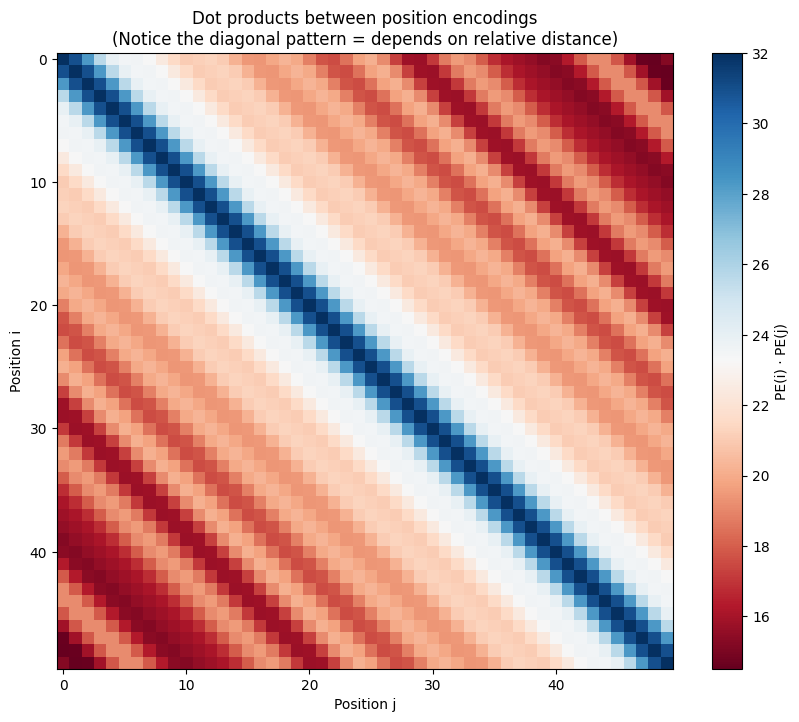

In [ ]:
# | dot-product-heatmap inline
# Let's compute dot products between all position pairs
pe_rel = positional_encoding(50, 64)
dot_products = pe_rel @ pe_rel.T

plt.figure(figsize=(10, 8))
plt.imshow(dot_products, cmap='RdBu')
plt.colorbar(label='PE(i) · PE(j)')
plt.xlabel('Position j')
plt.ylabel('Position i')
plt.title('Dot products between position encodings\n(Notice the diagonal pattern = depends on relative distance)')
plt.show()


In [ ]:
# | relative-distance-proof inline expanded
# The dot product depends mainly on the DIFFERENCE between positions
# PE(5) · PE(8) ≈ PE(10) · PE(13) because both have distance 3

print("Dot products for pairs with same relative distance:\n")
print("Positions      | Distance | Dot Product")
print("-" * 45)

for offset in [0, 3, 20]:
    pairs = [(0, 0+offset), (10, 10+offset), (25, 25+offset)]
    dots = [np.dot(pe_rel[i], pe_rel[j]) for i, j in pairs]
    print(f"(0,{offset}), (10,{10+offset}), (25,{25+offset}) |    {offset}     | {dots[0]:.2f}, {dots[1]:.2f}, {dots[2]:.2f}")
    
print("\n→ Same relative distance = similar dot products!")


Dot products for pairs with same relative distance:

Positions      | Distance | Dot Product
---------------------------------------------
(0,0), (10,10), (25,25) |    0     | 32.00, 32.00, 32.00
(0,3), (10,13), (25,28) |    3     | 25.59, 25.59, 25.59
(0,20), (10,30), (25,45) |    20     | 18.88, 18.88, 18.88

→ Same relative distance = similar dot products!


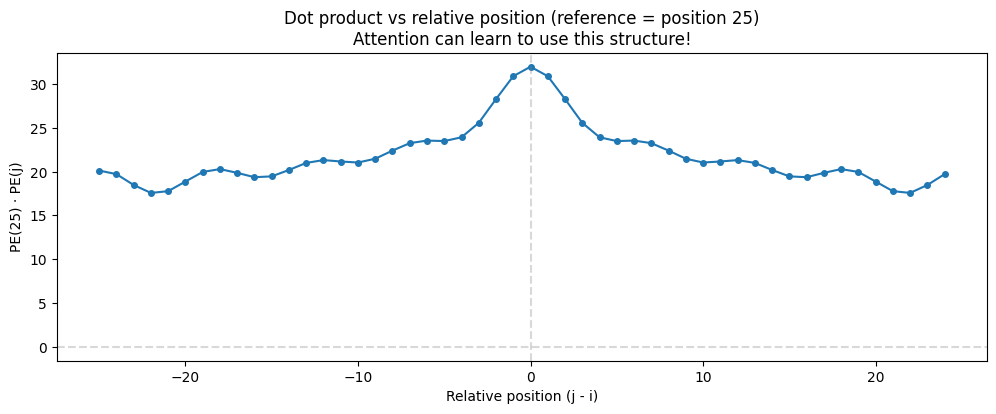

→ The dot product decays smoothly with distance
→ This gives the model a signal about relative position!


In [ ]:
# | dot-vs-distance inline
# How does dot product vary with relative distance?
# Pick a reference position and compute dot product with all other positions

# Use pe_rel from earlier (50 positions) OR create it here
pe_rel = positional_encoding(50, 64)

reference_pos = 25
dot_vs_distance = pe_rel[reference_pos] @ pe_rel.T  # using pe_rel, not pe

plt.figure(figsize=(12, 4))
plt.plot(np.arange(50) - reference_pos, dot_vs_distance, 'o-', markersize=4)
plt.xlabel('Relative position (j - i)')
plt.ylabel('PE(25) · PE(j)')
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.3)
plt.title(f'Dot product vs relative position (reference = position {reference_pos})\nAttention can learn to use this structure!')
plt.show()

print("→ The dot product decays smoothly with distance")
print("→ This gives the model a signal about relative position!")

## Summary: The Formula Demystified

Now the original formula should make sense:

$$PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{2i/d}}\right)$$
$$PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{2i/d}}\right)$$

| Component | What it does |
|-----------|--------------|
| `pos` | The position in the sequence (0, 1, 2, ...) |
| `i` | Which dimension pair we're computing (0 to d/2-1) |
| `d` | Total embedding dimension |
| `10000^(2i/d)` | Scales frequency: i=0 gives high freq, i=d/2 gives low freq |
| `sin` / `cos` | Orthogonal signals at each frequency |
| Alternating | Even dims get sin, odd dims get cos |

**Why this works:**
- Multiple frequencies → unique encoding per position
- High frequencies → distinguish nearby positions  
- Low frequencies → avoid repetition over long contexts
- Sin + cos → orthogonal, complete representation of rotation
- Linear transformation → can extract relative positions


In [322]:
# | pytorch-implementation inline
import torch

def sinusoidal_positional_encoding(max_len: int, d_model: int) -> torch.Tensor:
    """
    Generate sinusoidal positional encodings as in "Attention Is All You Need".
    
    Args:
        max_len: Maximum sequence length
        d_model: Embedding dimension (must be even)
        
    Returns:
        Tensor of shape (max_len, d_model)
    """
    position = torch.arange(max_len).unsqueeze(1)  # (max_len, 1)
    div_term = torch.exp(
        torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model)
    )  # (d_model/2,)
    
    pe = torch.zeros(max_len, d_model)
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    
    return pe

# Test it
pe_torch = sinusoidal_positional_encoding(100, 64)
print(f"Shape: {pe_torch.shape}")
print(f"Values in range [{pe_torch.min():.2f}, {pe_torch.max():.2f}]")

Shape: torch.Size([100, 64])
Values in range [-1.00, 1.00]


## Limitations

This sinusoidal encoding has served well.

However, it has a big limitation: **position info gets "mixed in"**. 

Since we add the positional encoding to token embeddings, the model has to disentangle them. The model *can* learn it through the dot product, but that's not guaranteed.

In [323]:
# | additive-pe-attention
# Let's see what happens when attention computes the dot product with additive PE
# In attention: score = (q + pe_i) · (k + pe_j)

# Using our "The", "cat", "sat" example
q = example_tensor[0].numpy()  # "The" as query (position 0)
k = example_tensor[1].numpy()  # "cat" as key (position 1)

pe = positional_encoding(3, 6)
pe_0 = pe[0]  # PE for position 0
pe_1 = pe[1]  # PE for position 1

# What the model sees after adding PE
q_with_pe = q + pe_0
k_with_pe = k + pe_1

# The attention score
score = np.dot(q_with_pe, k_with_pe)

print("Computing attention score: (q + pe_i) · (k + pe_j)")
print()
print(f"q (The):     {q.round(3)}")
print(f"pe_0:        {pe_0.round(3)}")
print(f"q + pe_0:    {q_with_pe.round(3)}")
print()
print(f"k (cat):     {k.round(3)}")
print(f"pe_1:        {pe_1.round(3)}")  
print(f"k + pe_1:    {k_with_pe.round(3)}")
print()
print(f"Attention score = {score:.4f}")


Computing attention score: (q + pe_i) · (k + pe_j)

q (The):     [ 0.601  0.109  1.253 -0.69   0.239  1.337]
pe_0:        [0. 1. 0. 1. 0. 1.]
q + pe_0:    [0.601 1.109 1.253 0.31  0.239 2.337]

k (cat):     [-0.573  0.537 -0.891  0.986 -0.319  0.321]
pe_1:        [0.841 0.54  0.046 0.999 0.002 1.   ]
k + pe_1:    [ 0.269  1.077 -0.844  1.985 -0.317  1.321]

Attention score = 3.9230


In [324]:
# | attention-four-terms
# Expand the dot product: (q + pe_i) · (k + pe_j) = q·k + q·pe_j + pe_i·k + pe_i·pe_j

term1 = np.dot(q, k)           # q · k (pure semantic similarity)
term2 = np.dot(q, pe_1)        # q · pe_j (query attending to position j)
term3 = np.dot(pe_0, k)        # pe_i · k (position i attending to key)
term4 = np.dot(pe_0, pe_1)     # pe_i · pe_j (pure positional relationship)

print("The dot product expands into 4 terms:")
print()
print(f"  q · k      = {term1:+.4f}  ← semantic similarity (what we want)")
print(f"  q · pe_j   = {term2:+.4f}  ← query content × position j")
print(f"  pe_i · k   = {term3:+.4f}  ← position i × key content")
print(f"  pe_i · pe_j = {term4:+.4f}  ← relative position (what we want)")
print(f"  ─────────────────────")
print(f"  Total      = {term1 + term2 + term3 + term4:+.4f}")
print()
print("⚠️ Problem: The position and content signals are mixed together!")
print("   The model has to learn to disentangle them.")


The dot product expands into 4 terms:

  q · k      = -1.7307  ← semantic similarity (what we want)
  q · pe_j   = +1.2706  ← query content × position j
  pe_i · k   = +1.8439  ← position i × key content
  pe_i · pe_j = +2.5392  ← relative position (what we want)
  ─────────────────────
  Total      = +3.9230

⚠️ Problem: The position and content signals are mixed together!
   The model has to learn to disentangle them.


### What We Ideally Want

We want the attention score to cleanly separate into:
1. **Semantic similarity**: How related are the tokens "The" and "cat"?
2. **Relative position**: How far apart are positions i and j?

With additive PE, we get 4 messy cross-terms. The model *can* learn to use the `pe_i · pe_j` term for relative position (as we showed earlier), but it's mixed in with content-position interactions.

**Question**: Can we encode position in a way that keeps semantic and positional signals separate?

## Alternative: Concatenation

One obvious solution: instead of adding position to the embedding, **concatenate** them:

$$\text{token\_with\_position} = [\text{embedding} ; \text{PE}]$$

This keeps them completely separate — the model can use different weight matrices to process semantic vs positional information.


In [ ]:
# | concatenation-approach inline
# Concatenation approach
# Instead of: token + PE → same dimension
# We do: [token, PE] → double the dimension

q_concat = np.concatenate([q, pe_0])
k_concat = np.concatenate([k, pe_1])

print("Concatenation approach:")
print(f"  Original q dimension: {len(q)}")
print(f"  PE dimension: {len(pe_0)}")
print(f"  Concatenated dimension: {len(q_concat)}")
print()
print(f"q_concat = [{q.round(2)} | {pe_0.round(2)}]")
print(f"k_concat = [{k.round(2)} | {pe_1.round(2)}]")


Concatenation approach:
  Original q dimension: 6
  PE dimension: 6
  Concatenated dimension: 12

q_concat = [[ 0.6   0.11  1.25 -0.69  0.24  1.34] | [0. 1. 0. 1. 0. 1.]]
k_concat = [[-0.57  0.54 -0.89  0.99 -0.32  0.32] | [0.84 0.54 0.05 1.   0.   1.  ]]


In [326]:
# | concatenation-cost
# The problem: concatenation increases dimension → increases computation

d_model = 512  # typical embedding dimension
pe_dim = 64    # positional encoding dimension

print("Computational cost comparison:")
print()
print(f"Addition approach:")
print(f"  Embedding dim: {d_model}")
print(f"  Attention matrix: {d_model} × {d_model} = {d_model**2:,} parameters")
print()
print(f"Concatenation approach:")
concat_dim = d_model + pe_dim
print(f"  Combined dim: {d_model} + {pe_dim} = {concat_dim}")
print(f"  Attention matrix: {concat_dim} × {concat_dim} = {concat_dim**2:,} parameters")
print()
print(f"Extra cost: {concat_dim**2 - d_model**2:,} parameters (+{100*(concat_dim**2/d_model**2 - 1):.1f}%)")
print("\n⚠️ This adds up quickly with multiple attention heads and layers!")


Computational cost comparison:

Addition approach:
  Embedding dim: 512
  Attention matrix: 512 × 512 = 262,144 parameters

Concatenation approach:
  Combined dim: 512 + 64 = 576
  Attention matrix: 576 × 576 = 331,776 parameters

Extra cost: 69,632 parameters (+26.6%)

⚠️ This adds up quickly with multiple attention heads and layers!


In practice, **addition works just as well** for deep models. The intuition is that deeper networks can learn to disentangle the mixed signals through their many layers. Concatenation is rarely used because the computational overhead isn't worth the marginal benefit.

### Brief Aside: Learned Positional Embeddings

Another approach: instead of using a fixed sinusoidal formula, just **learn** the positional embeddings as parameters!

```
PE = nn.Embedding(max_len, d_model)  # learnable lookup table
```

The intuition here is that the model will learn how to use the positional embeddings to attend to the correct positions as part of the training process.

This is used in BERT and GPT-2. It works well but has limitations:
- **Fixed maximum length**: Can't extrapolate beyond positions seen in training
- **No inherent structure**: The model has to learn from scratch that position 5 and 6 are related
- **More parameters**: Need to store max_len × d_model values

Sinusoidal embeddings have a mathematical structure that generalizes better, which is why they're still widely used (and why RoPE builds on them).


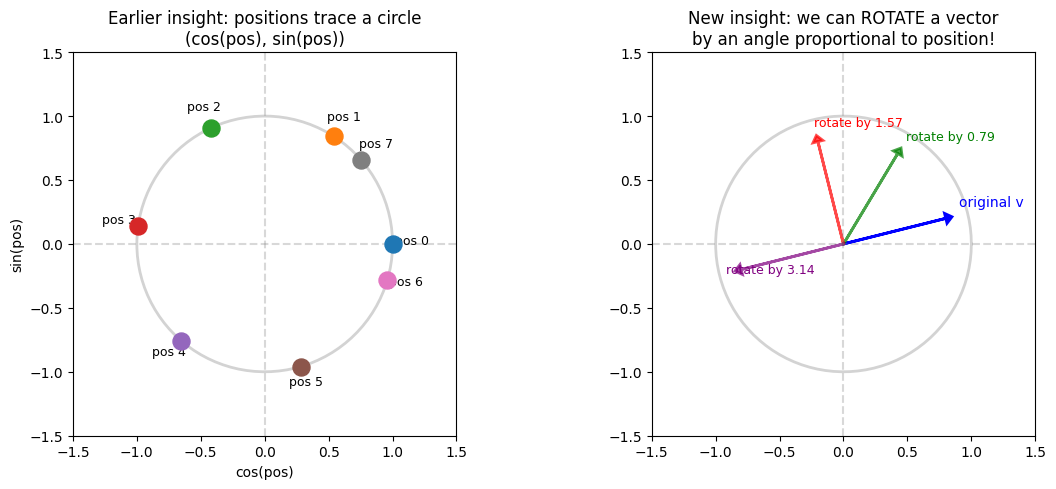

Key idea: Instead of ADDING a position vector, we ROTATE by a position-dependent angle!


In [ ]:
# | circle-rotation-intro inline 
# Recall: (cos(θ), sin(θ)) traces a circle as θ increases
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Left: The circle traced by (cos, sin)
theta = np.linspace(0, 2*np.pi, 100)
ax1.plot(np.cos(theta), np.sin(theta), 'lightgray', linewidth=2)

positions = np.arange(8)
for pos in positions:
    ax1.scatter(np.cos(pos), np.sin(pos), s=150, zorder=5)
    ax1.annotate(f'pos {pos}', (np.cos(pos)*1.15, np.sin(pos)*1.15), ha='center', fontsize=9)

ax1.set_xlim(-1.5, 1.5)
ax1.set_ylim(-1.5, 1.5)
ax1.set_aspect('equal')
ax1.set_xlabel('cos(pos)')
ax1.set_ylabel('sin(pos)')
ax1.set_title('Earlier insight: positions trace a circle\n(cos(pos), sin(pos))')
ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
ax1.axvline(x=0, color='gray', linestyle='--', alpha=0.3)

# Right: This is rotation!
ax2.plot(np.cos(theta), np.sin(theta), 'lightgray', linewidth=2)

# Show a vector and its rotations
v = np.array([0.8, 0.2])  # some vector
ax2.arrow(0, 0, v[0], v[1], head_width=0.08, head_length=0.05, fc='blue', ec='blue', linewidth=2)
ax2.annotate('original v', (v[0]+0.1, v[1]+0.1), fontsize=10, color='blue')

# Rotate by different angles
for angle, color in [(np.pi/4, 'green'), (np.pi/2, 'red'), (np.pi, 'purple')]:
    rot = np.array([[np.cos(angle), -np.sin(angle)],
                    [np.sin(angle), np.cos(angle)]])
    v_rot = rot @ v
    ax2.arrow(0, 0, v_rot[0], v_rot[1], head_width=0.08, head_length=0.05, 
              fc=color, ec=color, linewidth=2, alpha=0.7)
    ax2.annotate(f'rotate by {angle:.2f}', (v_rot[0]*1.15, v_rot[1]*1.15), fontsize=9, color=color)

ax2.set_xlim(-1.5, 1.5)
ax2.set_ylim(-1.5, 1.5)
ax2.set_aspect('equal')
ax2.set_title('New insight: we can ROTATE a vector\nby an angle proportional to position!')
ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
ax2.axvline(x=0, color='gray', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

print("Key idea: Instead of ADDING a position vector, we ROTATE by a position-dependent angle!")


### 2D Rotation Refresher

A 2D rotation matrix rotates a vector by angle θ:

$$R(\theta) = \begin{pmatrix} \cos\theta & -\sin\theta \\ \sin\theta & \cos\theta \end{pmatrix}$$

Applying it to a 2D vector:

$$R(\theta) \begin{pmatrix} x \\ y \end{pmatrix} = \begin{pmatrix} x\cos\theta - y\sin\theta \\ x\sin\theta + y\cos\theta \end{pmatrix}$$

Key property: **rotation preserves the vector's magnitude** (length). This is important — we don't want position encoding to change how "big" our embeddings are.

In [ ]:
# | rotation-2d-function inline expanded
# Let's implement 2D rotation
def rotate_2d(v, theta):
    """Rotate a 2D vector by angle theta."""
    cos_t = np.cos(theta)
    sin_t = np.sin(theta)
    R = np.array([[cos_t, -sin_t],
                  [sin_t, cos_t]])
    return R @ v

# Example: rotate a vector
v = np.array([1.0, 0.0])  # unit vector pointing right
theta = np.pi / 4  # 45 degrees

v_rotated = rotate_2d(v, theta)

print(f"Original vector: {v}")
print(f"Rotated by π/4:  {v_rotated.round(4)}")
print()
print(f"Original magnitude: {np.linalg.norm(v):.4f}")
print(f"Rotated magnitude:  {np.linalg.norm(v_rotated):.4f}")
print("\n✓ Magnitude preserved!")


Original vector: [1. 0.]
Rotated by π/4:  [0.7071 0.7071]

Original magnitude: 1.0000
Rotated magnitude:  1.0000

✓ Magnitude preserved!


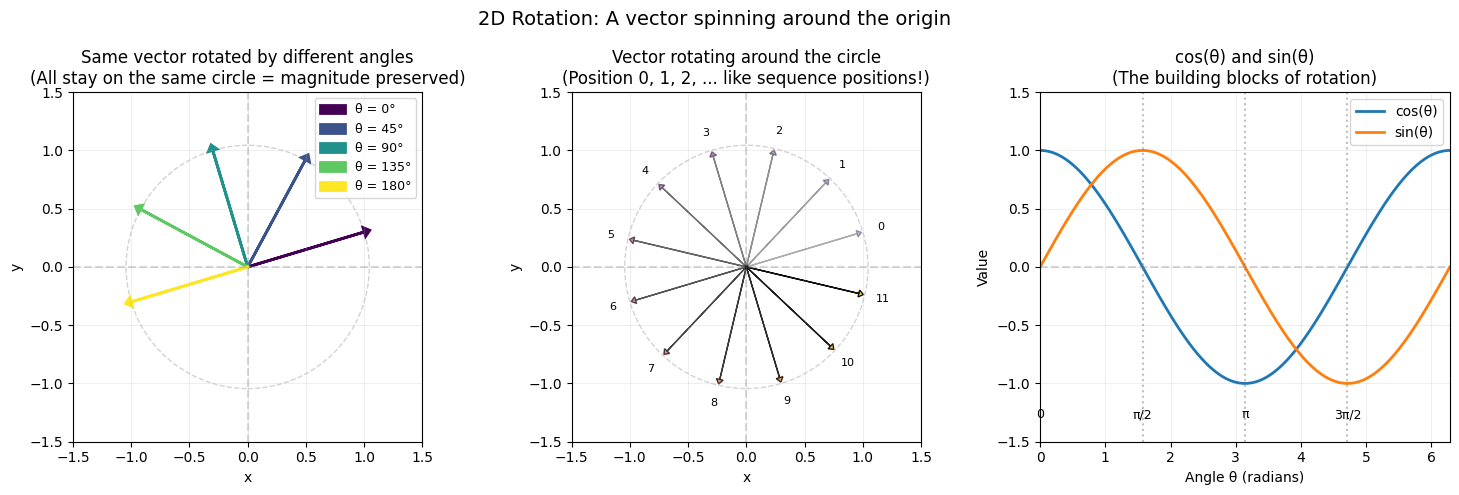

Key insight: Rotation is just moving a vector around a circle!
The vector's LENGTH stays the same — only its DIRECTION changes.


In [ ]:
# | rotation-visualization inline 
# Visualization: What does 2D rotation look like?
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original vector
v = np.array([1.0, 0.3])

# Different rotation angles to demonstrate
angles = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi]
angle_labels = ['0°', '45°', '90°', '135°', '180°']
colors = plt.cm.viridis(np.linspace(0, 1, len(angles)))

# Left: Show vector rotating to different angles
ax1 = axes[0]
circle = plt.Circle((0, 0), np.linalg.norm(v), fill=False, color='lightgray', linestyle='--')
ax1.add_patch(circle)

for angle, label, color in zip(angles, angle_labels, colors):
    v_rot = rotate_2d(v, angle)
    ax1.arrow(0, 0, v_rot[0], v_rot[1], head_width=0.08, head_length=0.05,
              fc=color, ec=color, linewidth=2, label=f'θ = {label}')

ax1.set_xlim(-1.5, 1.5)
ax1.set_ylim(-1.5, 1.5)
ax1.set_aspect('equal')
ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
ax1.axvline(x=0, color='gray', linestyle='--', alpha=0.3)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('Same vector rotated by different angles\n(All stay on the same circle = magnitude preserved)')
ax1.legend(loc='upper right', fontsize=9)
ax1.grid(True, alpha=0.2)

# Middle: Animate-like sequence showing rotation
ax2 = axes[1]
n_steps = 12
theta_steps = np.linspace(0, 2*np.pi, n_steps, endpoint=False)

circle2 = plt.Circle((0, 0), np.linalg.norm(v), fill=False, color='lightgray', linestyle='--')
ax2.add_patch(circle2)

for i, theta in enumerate(theta_steps):
    v_rot = rotate_2d(v, theta)
    alpha = 0.3 + 0.7 * (i / n_steps)
    ax2.arrow(0, 0, v_rot[0]*0.95, v_rot[1]*0.95, head_width=0.06, head_length=0.04,
              fc=plt.cm.plasma(i/n_steps), ec='black', linewidth=1, alpha=alpha)
    ax2.text(v_rot[0]*1.15, v_rot[1]*1.15, f'{i}', fontsize=8, ha='center', va='center')

ax2.set_xlim(-1.5, 1.5)
ax2.set_ylim(-1.5, 1.5)
ax2.set_aspect('equal')
ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
ax2.axvline(x=0, color='gray', linestyle='--', alpha=0.3)
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_title('Vector rotating around the circle\n(Position 0, 1, 2, ... like sequence positions!)')
ax2.grid(True, alpha=0.2)

# Right: Show the rotation matrix components
ax3 = axes[2]
thetas = np.linspace(0, 2*np.pi, 100)
ax3.plot(thetas, np.cos(thetas), label='cos(θ)', linewidth=2)
ax3.plot(thetas, np.sin(thetas), label='sin(θ)', linewidth=2)
ax3.axhline(y=0, color='gray', linestyle='--', alpha=0.3)

# Mark specific angles
for angle, label in [(0, '0'), (np.pi/2, 'π/2'), (np.pi, 'π'), (3*np.pi/2, '3π/2')]:
    ax3.axvline(x=angle, color='gray', linestyle=':', alpha=0.5)
    ax3.text(angle, -1.3, label, ha='center', fontsize=9)

ax3.set_xlabel('Angle θ (radians)')
ax3.set_ylabel('Value')
ax3.set_title('cos(θ) and sin(θ)\n(The building blocks of rotation)')
ax3.legend(fontsize=10)
ax3.set_xlim(0, 2*np.pi)
ax3.set_ylim(-1.5, 1.5)
ax3.grid(True, alpha=0.2)

plt.suptitle('2D Rotation: A vector spinning around the origin', fontsize=14)
plt.tight_layout()
plt.show()

print("Key insight: Rotation is just moving a vector around a circle!")
print("The vector's LENGTH stays the same — only its DIRECTION changes.")

### The Magic Property of Rotation

Here's the key insight that makes RoPE work. When we take the dot product of two vectors that have been rotated by different angles:

$$R(\theta_i) \mathbf{q} \cdot R(\theta_j) \mathbf{k} = \mathbf{q}^T R(\theta_i - \theta_j) \mathbf{k}$$

**The dot product depends on the DIFFERENCE of angles!**

If we set `θ = position × frequency`, then the dot product depends on `(pos_i - pos_j) × frequency` — the **relative position** is explicit!

In [ ]:
# | magic-property-verify inline expanded
# Let's verify this magic property!
# Take two 2D vectors, rotate by different angles, and compute dot product

q_2d = np.array([0.8, 0.3])  # some query vector
k_2d = np.array([0.5, 0.7])  # some key vector

theta_i = 0.5  # angle for position i
theta_j = 0.3  # angle for position j

# Method 1: Rotate each vector, then dot product
q_rotated = rotate_2d(q_2d, theta_i)
k_rotated = rotate_2d(k_2d, theta_j)
dot_method1 = np.dot(q_rotated, k_rotated)

# Method 2: Rotate k by the DIFFERENCE, then dot with original q
k_rotated_by_diff = rotate_2d(k_2d, theta_j - theta_i)
dot_method2 = np.dot(q_2d, k_rotated_by_diff)

print(f"θ_i = {theta_i}, θ_j = {theta_j}, difference = {theta_j - theta_i}")
print()
print(f"Method 1: R(θ_i)q · R(θ_j)k = {dot_method1:.6f}")
print(f"Method 2: q · R(θ_j - θ_i)k = {dot_method2:.6f}")
print()
print("✓ They're equal! The dot product only depends on the angle DIFFERENCE.")


θ_i = 0.5, θ_j = 0.3, difference = -0.2

Method 1: R(θ_i)q · R(θ_j)k = 0.679295
Method 2: q · R(θ_j - θ_i)k = 0.679295

✓ They're equal! The dot product only depends on the angle DIFFERENCE.


In [ ]:
# | position-rotation-demo inline 
# Now let's apply this to positions!
# Set θ = position × frequency

frequency = 1.0  # same as our earlier high frequency

# Compare dot products for pairs with the same relative distance
print("Dot products for pairs with same RELATIVE position:\n")
print("Positions (i, j) | Distance | Dot product")
print("-" * 50)

for pos_i, pos_j in [(0, 3), (5, 8), (10, 13)]:
    theta_i = pos_i * frequency
    theta_j = pos_j * frequency
    q_rot = rotate_2d(q_2d, theta_i)
    k_rot = rotate_2d(k_2d, theta_j)
    dot = np.dot(q_rot, k_rot)
    print(f"    ({pos_i}, {pos_j})       |    {pos_j - pos_i}     |   {dot:.6f}")

print("\n✓ Same relative distance (3) → same dot product!")
print("The relative position is EXPLICIT in the computation.")


Dot products for pairs with same RELATIVE position:

Positions (i, j) | Distance | Dot product
--------------------------------------------------
    (0, 3)       |    3     |   -0.661755
    (5, 8)       |    3     |   -0.661755
    (10, 13)       |    3     |   -0.661755

✓ Same relative distance (3) → same dot product!
The relative position is EXPLICIT in the computation.


### The Math: Why Rotation Makes Relative Position Explicit

Let's work through why the dot product of two rotated vectors depends only on the **difference** of their rotation angles.

#### Setup

We have two vectors **q** and **k**, and we rotate them by angles θ₁ and θ₂ respectively:

$$\mathbf{q}' = R(\theta_1) \mathbf{q}, \quad \mathbf{k}' = R(\theta_2) \mathbf{k}$$

We want to compute the dot product: $\mathbf{q}' \cdot \mathbf{k}'$

#### Step 1: Write out the rotated vectors

For a 2D vector $\mathbf{q} = (q_x, q_y)$:

$$R(\theta_1) \mathbf{q} = \begin{pmatrix} q_x \cos\theta_1 - q_y \sin\theta_1 \\ q_x \sin\theta_1 + q_y \cos\theta_1 \end{pmatrix}$$

Similarly for $\mathbf{k} = (k_x, k_y)$:

$$R(\theta_2) \mathbf{k} = \begin{pmatrix} k_x \cos\theta_2 - k_y \sin\theta_2 \\ k_x \sin\theta_2 + k_y \cos\theta_2 \end{pmatrix}$$

#### Step 2: Compute the dot product

$$\mathbf{q}' \cdot \mathbf{k}' = (q_x \cos\theta_1 - q_y \sin\theta_1)(k_x \cos\theta_2 - k_y \sin\theta_2) + (q_x \sin\theta_1 + q_y \cos\theta_1)(k_x \sin\theta_2 + k_y \cos\theta_2)$$

#### Step 3: Expand and simplify (using trig identities)

After expanding (tedious but straightforward), we get:

$$\mathbf{q}' \cdot \mathbf{k}' = q_x k_x \cos(\theta_1 - \theta_2) + q_y k_y \cos(\theta_1 - \theta_2) + q_x k_y \sin(\theta_2 - \theta_1) + q_y k_x \sin(\theta_1 - \theta_2)$$

This can be written as:

$$\mathbf{q}' \cdot \mathbf{k}' = \mathbf{q}^T R(\theta_1 - \theta_2) \mathbf{k}$$

**The dot product only depends on $\theta_1 - \theta_2$, the difference of angles!**

#### Concrete Example

Let's verify with numbers:
- $\mathbf{q} = (0.8, 0.3)$
- $\mathbf{k} = (0.5, 0.7)$
- $\theta_1 = 0.6$ (position 1 with some frequency)
- $\theta_2 = 0.4$ (position 2 with same frequency)
- $\theta_1 - \theta_2 = 0.2$

**Method 1**: Rotate each vector, then dot product
$$\mathbf{q}' \cdot \mathbf{k}' = R(0.6)\mathbf{q} \cdot R(0.4)\mathbf{k}$$

**Method 2**: Rotate **k** by the difference, then dot with original **q**
$$\mathbf{q} \cdot R(0.2)\mathbf{k}$$

Both give the **same answer** — we verified this in code above!

#### Why This Matters for RoPE

In RoPE, we set:
$$\theta = \text{position} \times \text{frequency}$$

So for query at position $i$ and key at position $j$:
$$\theta_i - \theta_j = (i - j) \times \text{frequency}$$

**The attention score depends only on $(i - j)$ — the relative position!**

This is the magic: by using rotation instead of addition, we've made relative position **explicit** in the computation, not something the model has to learn to extract.

#### Why We Can't Just Rotate the Embedding

You might wonder: why apply RoPE to Q and K specifically? Why not just rotate the embedding directly?

The answer is subtle but important. If we rotated the embedding **before** the linear projection:

$$\mathbf{q} = W_q \cdot R(\theta) \cdot \mathbf{x}$$

But rotation $R(\theta)$ is a **linear transformation**, and so is $W_q$. Matrix multiplication is associative, so:

$$W_q \cdot R(\theta) \cdot \mathbf{x} = (W_q \cdot R(\theta)) \cdot \mathbf{x} = W'_q \cdot \mathbf{x}$$

This is just a **different projection matrix** $W'_q$ for each position! The model could learn this anyway — we haven't added anything new. It's effectively the same as having position-dependent projection weights, which is just a more expensive form of positional encoding.

**The key insight**: RoPE must be applied **after** the projection because:
1. We want the rotation to directly affect the **dot product** in attention
2. If applied before projection, the linear projection "absorbs" the rotation
3. By rotating Q and K after projection, the rotation survives to the attention computation

This is why RoPE specifically rotates the Q and K vectors, not the input embeddings. The rotation needs to happen at the point where it will directly influence how tokens attend to each other based on their relative positions.

In [334]:
# | rope-apply-function inline expanded
# Apply RoPE to a higher-dimensional vector
# Our example_tensor has 6 dimensions → 3 pairs

def apply_rope(v, position, d_model, base=10000):
    """
    Apply Rotary Position Embedding to a vector.
    
    Args:
        v: vector of shape (d_model,)
        position: integer position in sequence
        d_model: embedding dimension (must be even)
        base: base for frequency computation (default 10000)
    
    Returns:
        rotated vector of same shape
    """
    result = np.zeros_like(v)
    
    # Process pairs of dimensions
    for i in range(d_model // 2):
        # Same frequency formula as sinusoidal PE!
        freq = 1.0 / (base ** (2 * i / d_model))
        theta = position * freq
        
        # Get the pair of dimensions
        x = v[2*i]
        y = v[2*i + 1]
        
        # Apply 2D rotation
        cos_t = np.cos(theta)
        sin_t = np.sin(theta)
        result[2*i] = x * cos_t - y * sin_t
        result[2*i + 1] = x * sin_t + y * cos_t
    
    return result


### What Exactly Gets Rotated in RoPE?

Let's be very explicit about the data flow:

#### Step-by-step breakdown

```
1. Token embedding:     x = embed("cat")           # shape: (d_model,)
                        ↓
2. Compute Q and K:     q = W_q @ x                # Linear projection, shape: (d_model,)
                        k = W_k @ x                # Linear projection, shape: (d_model,)
                        ↓
3. Apply RoPE:          q_rotated = rotate(q, θ)   # ← THIS is where rotation happens
                        k_rotated = rotate(k, θ)   # ← Rotate the Q and K vectors
                        ↓
4. Attention:           score = q_rotated · k_rotated
```

**The embedding `x` is NEVER modified.** 

**The Q and K vectors ARE modified — they get rotated.**

#### What does "rotate Q and K" mean concretely?

The Q and K vectors have `d_model` dimensions (e.g., 64 or 512). We:

1. **Pair up dimensions**: (0,1), (2,3), (4,5), ...
2. **For each pair**, apply a 2D rotation with angle θ = position × frequency

```
Before RoPE:  q = [q₀, q₁, q₂, q₃, q₄, q₅, ...]
                   \_____/  \_____/  \_____/
                   pair 0   pair 1   pair 2

After RoPE:   q' = [q₀', q₁', q₂', q₃', q₄', q₅', ...]
              where each pair is rotated:
              (q₀', q₁') = rotate_2d((q₀, q₁), θ₀)
              (q₂', q₃') = rotate_2d((q₂, q₃), θ₁)
              ...
```

Each pair gets its own rotation angle based on:
- The **position** of the token in the sequence
- The **frequency** for that dimension pair (same 10000 base formula!)

#### Visual summary

```
Additive PE:                          RoPE:
                                      
x ──────► x + PE ──► W_q ──► q        x ──► W_q ──► q ──► rotate(q) ──► q'
                                      
embedding gets modified then projected    embedding projected then THEN rotate
                               
```

**Key difference**: In additive PE, position is mixed into the embedding before projection. In RoPE, Q and K are computed cleanly, then rotated based on position. The position encoding happens **after** the linear transformation, not before.

### Extending to Higher Dimensions

Our embeddings have more than 2 dimensions. How do we rotate a 6D or 512D vector?

**Key insight**: Remember how we paired dimensions in sinusoidal PE? We used (sin, cos) pairs for each frequency. RoPE does the same thing!

We pair up dimensions: (0,1), (2,3), (4,5), ... and apply a **separate 2D rotation** to each pair. Each pair gets a different frequency — exactly like sinusoidal PE!

In [358]:
# | rope-qk-rotation inline
# CORRECTED: How RoPE actually works
# RoPE is applied to Q and K vectors, NOT to embeddings directly

tokens = ["The", "cat", "sat"]

# Simulate the projection matrices W_q and W_k
np.random.seed(123)
d_model = 6
W_q = np.random.randn(d_model, d_model) * 0.5
W_k = np.random.randn(d_model, d_model) * 0.5

print("How RoPE ACTUALLY works:\n")
print("=" * 60)

for pos, token in enumerate(tokens):
    embedding = example_tensor[pos].numpy()
    
    # Step 1: Project embedding to get Q and K (standard attention)
    q = W_q @ embedding
    k = W_k @ embedding
    
    # Step 2: Apply RoPE to Q and K (NOT to embedding!)
    q_rotated = apply_rope(q, position=pos, d_model=d_model)
    k_rotated = apply_rope(k, position=pos, d_model=d_model)
    
    print(f'"{token}" at position {pos}:')
    print(f"  1. Embedding x:        {embedding.round(3)}")
    print(f"  2. Q = W_q @ x:        {q.round(3)}")
    print(f"  3. K = W_k @ x:        {k.round(3)}")
    print(f"  4. Q after RoPE:       {q_rotated.round(3)}")
    print(f"  5. K after RoPE:       {k_rotated.round(3)}")
    print(f"  Q magnitude: {np.linalg.norm(q):.4f} → {np.linalg.norm(q_rotated):.4f} ✓")
    print()

print("Key point: The EMBEDDING is unchanged!")
print("RoPE only rotates Q and K AFTER they're projected from the embedding.")

How RoPE ACTUALLY works:

"The" at position 0:
  1. Embedding x:        [ 0.601  0.109  1.253 -0.69   0.239  1.337]
  2. Q = W_q @ x:        [ 1.459  0.195  2.011  0.944  0.057 -1.102]
  3. K = W_k @ x:        [-1.862  0.692 -0.361  0.913  1.175 -1.318]
  4. Q after RoPE:       [ 1.459  0.195  2.011  0.944  0.057 -1.102]
  5. K after RoPE:       [-1.862  0.692 -0.361  0.913  1.175 -1.318]
  Q magnitude: 2.8846 → 2.8846 ✓

"cat" at position 1:
  1. Embedding x:        [-0.573  0.537 -0.891  0.986 -0.319  0.321]
  2. Q = W_q @ x:        [ 0.067 -0.318 -0.617  0.561 -1.036 -0.41 ]
  3. K = W_k @ x:        [ 0.567 -0.206 -0.022  0.68  -0.456  0.348]
  4. Q after RoPE:       [ 0.304 -0.116 -0.642  0.532 -1.036 -0.412]
  5. K after RoPE:       [ 0.48   0.366 -0.054  0.678 -0.457  0.347]
  Q magnitude: 1.4293 → 1.4293 ✓

"sat" at position 2:
  1. Embedding x:        [-0.197 -0.777 -1.466 -1.087  0.347  0.957]
  2. Q = W_q @ x:        [ 1.021 -0.215  2.093 -1.199  0.046  2.869]
  3. K = W_k @ 

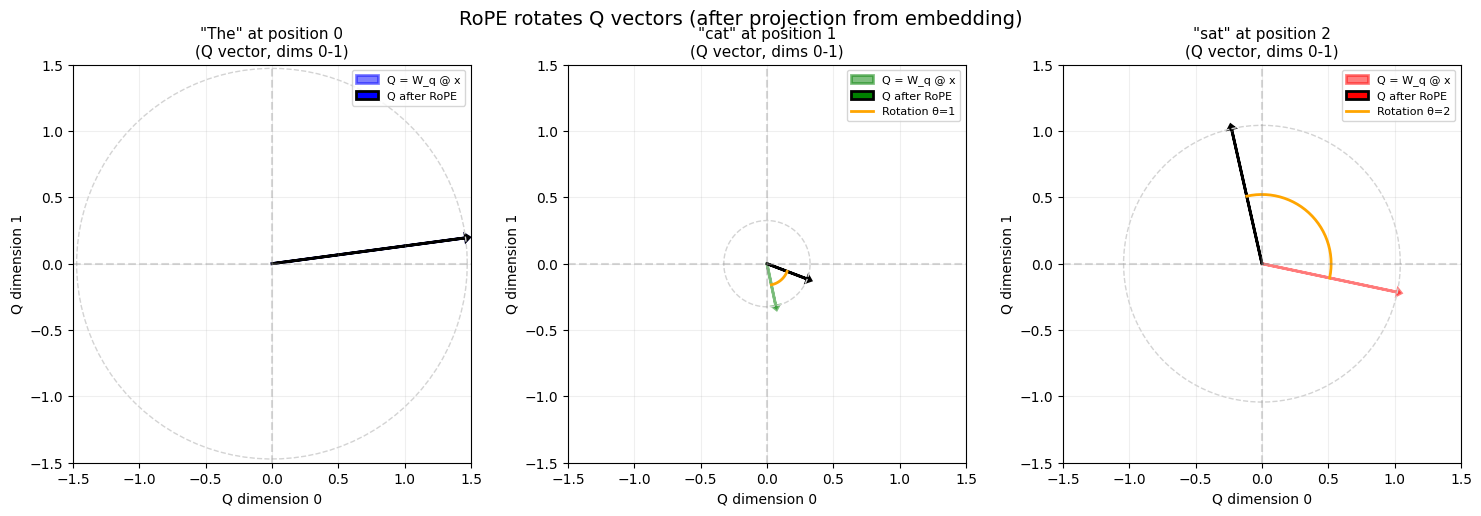

Remember: x (embedding) → W_q @ x (Q vector) → RoPE rotation
Position 0: No rotation (θ = 0)
Position 1: Q rotated by θ = 1 × frequency
Position 2: Q rotated by θ = 2 × frequency

The dashed circle shows Q's magnitude is preserved by rotation!


In [359]:
# | rope-q-visualization inline
# Visualization of RoPE rotating Q vectors (NOT embeddings directly)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

tokens = ["The", "cat", "sat"]
colors = ['blue', 'green', 'red']

# Projection matrix (same as before)
np.random.seed(123)
W_q = np.random.randn(6, 6) * 0.5

for idx, (ax, token, color) in enumerate(zip(axes, tokens, colors)):
    embedding = example_tensor[idx].numpy()
    
    # First project to get Q vector
    q = W_q @ embedding
    
    # Then apply RoPE to Q
    q_rotated = apply_rope(q, position=idx, d_model=6)
    
    # Plot the first pair of dimensions (dims 0 and 1 - highest frequency)
    q_2d = q[:2]
    q_rot_2d = q_rotated[:2]
    
    # Draw circle showing magnitude is preserved
    magnitude = np.linalg.norm(q_2d)
    theta = np.linspace(0, 2*np.pi, 100)
    ax.plot(magnitude * np.cos(theta), magnitude * np.sin(theta), 'lightgray', linewidth=1, linestyle='--')
    
    # Plot original Q vector
    ax.arrow(0, 0, q_2d[0], q_2d[1], head_width=0.05, head_length=0.03, 
             fc=color, ec=color, linewidth=2, alpha=0.5, label='Q = W_q @ x')
    
    # Plot rotated Q vector
    ax.arrow(0, 0, q_rot_2d[0], q_rot_2d[1], head_width=0.05, head_length=0.03,
             fc=color, ec='black', linewidth=2, label='Q after RoPE')
    
    # Draw arc showing the rotation
    if idx > 0:  # Position 0 has no rotation
        angle_orig = np.arctan2(q_2d[1], q_2d[0])
        angle_rot = np.arctan2(q_rot_2d[1], q_rot_2d[0])
        arc_angles = np.linspace(angle_orig, angle_rot, 30)
        arc_r = magnitude * 0.5
        ax.plot(arc_r * np.cos(arc_angles), arc_r * np.sin(arc_angles), 
                color='orange', linewidth=2, label=f'Rotation θ={idx}')
    
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    ax.set_aspect('equal')
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
    ax.axvline(x=0, color='gray', linestyle='--', alpha=0.3)
    ax.set_xlabel('Q dimension 0', fontsize=10)
    ax.set_ylabel('Q dimension 1', fontsize=10)
    ax.set_title(f'"{token}" at position {idx}\n(Q vector, dims 0-1)', fontsize=11)
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.2)

plt.suptitle('RoPE rotates Q vectors (after projection from embedding)', fontsize=14)
plt.tight_layout()
plt.show()

print("Remember: x (embedding) → W_q @ x (Q vector) → RoPE rotation")
print("Position 0: No rotation (θ = 0)")
print("Position 1: Q rotated by θ = 1 × frequency")  
print("Position 2: Q rotated by θ = 2 × frequency")
print("\nThe dashed circle shows Q's magnitude is preserved by rotation!")

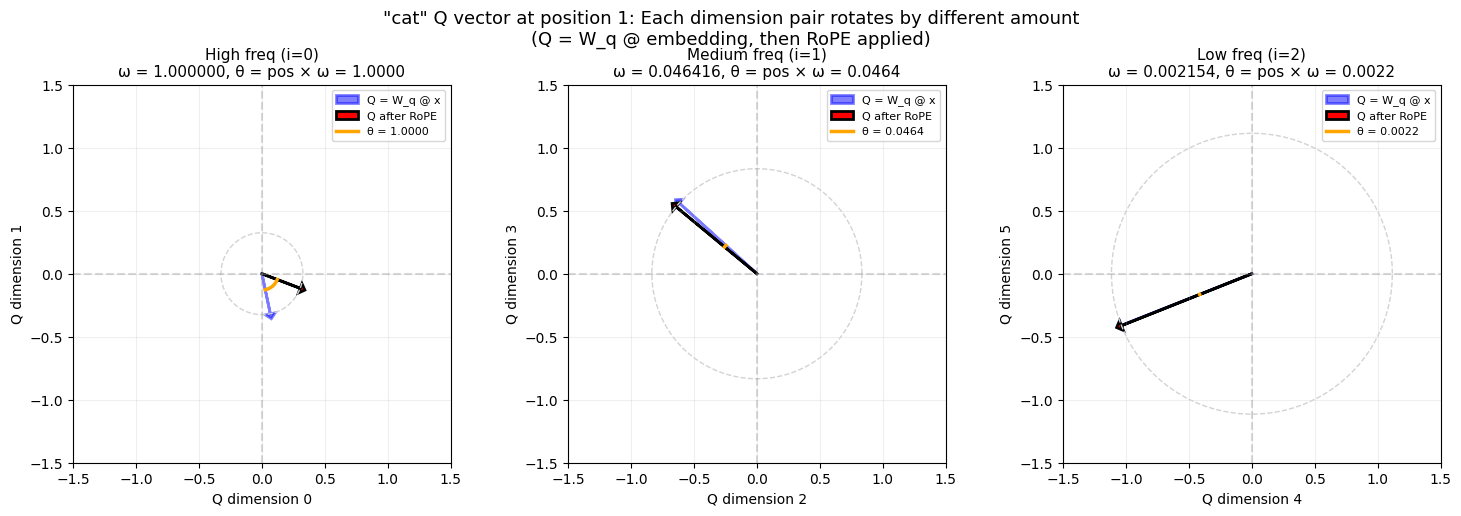

Same Q vector, same position, but each dimension pair has a DIFFERENT rotation angle!
This is exactly like sinusoidal PE — multiple frequencies capture different scales.

Dims 0-1: ω = 1.0,      θ = 1.0000 (large rotation)
Dims 2-3: ω = 0.0464,   θ = 0.0464 (small rotation)
Dims 4-5: ω = 0.00215,  θ = 0.0022 (tiny rotation)


In [360]:
# | rope-freq-pairs inline
# Visualization: One Q vector, all dimension pairs (showing different frequencies)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

token = "cat"
pos = 1
embedding = example_tensor[pos].numpy()

# Project to get Q vector first
np.random.seed(123)
W_q = np.random.randn(6, 6) * 0.5
q = W_q @ embedding

# Then apply RoPE to Q
q_rotated = apply_rope(q, position=pos, d_model=6)

dim_pairs = [(0, 1), (2, 3), (4, 5)]
freq_labels = ['High freq (i=0)', 'Medium freq (i=1)', 'Low freq (i=2)']

for ax, (d1, d2), freq_label in zip(axes, dim_pairs, freq_labels):
    q_2d = np.array([q[d1], q[d2]])
    q_rot_2d = np.array([q_rotated[d1], q_rotated[d2]])
    
    # Compute frequency and rotation angle
    freq = 1.0 / (10000 ** (d1 / 6))
    theta = pos * freq
    
    # Draw circle showing magnitude is preserved
    magnitude = np.linalg.norm(q_2d)
    circle_theta = np.linspace(0, 2*np.pi, 100)
    ax.plot(magnitude * np.cos(circle_theta), magnitude * np.sin(circle_theta), 
            'lightgray', linewidth=1, linestyle='--')
    
    # Plot original Q vector
    ax.arrow(0, 0, q_2d[0], q_2d[1], head_width=0.08, head_length=0.04,
             fc='blue', ec='blue', linewidth=2, alpha=0.5, label='Q = W_q @ x')
    
    # Plot rotated Q vector  
    ax.arrow(0, 0, q_rot_2d[0], q_rot_2d[1], head_width=0.08, head_length=0.04,
             fc='red', ec='black', linewidth=2, label='Q after RoPE')
    
    # Draw arc showing the rotation
    angle_orig = np.arctan2(q_2d[1], q_2d[0])
    angle_rot = np.arctan2(q_rot_2d[1], q_rot_2d[0])
    arc_angles = np.linspace(angle_orig, angle_rot, 30)
    arc_r = magnitude * 0.4
    ax.plot(arc_r * np.cos(arc_angles), arc_r * np.sin(arc_angles),
            color='orange', linewidth=2.5, label=f'θ = {theta:.4f}')
    
    max_val = max(1.5, magnitude * 1.3)
    ax.set_xlim(-max_val, max_val)
    ax.set_ylim(-max_val, max_val)
    ax.set_aspect('equal')
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
    ax.axvline(x=0, color='gray', linestyle='--', alpha=0.3)
    ax.set_xlabel(f'Q dimension {d1}', fontsize=10)
    ax.set_ylabel(f'Q dimension {d2}', fontsize=10)
    ax.set_title(f'{freq_label}\nω = {freq:.6f}, θ = pos × ω = {theta:.4f}', fontsize=11)
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.2)

plt.suptitle(f'"{token}" Q vector at position {pos}: Each dimension pair rotates by different amount\n(Q = W_q @ embedding, then RoPE applied)', fontsize=13)
plt.tight_layout()
plt.show()

print("Same Q vector, same position, but each dimension pair has a DIFFERENT rotation angle!")
print("This is exactly like sinusoidal PE — multiple frequencies capture different scales.")
print(f"\nDims 0-1: ω = 1.0,      θ = {pos * 1.0:.4f} (large rotation)")
print(f"Dims 2-3: ω = 0.0464,   θ = {pos * 0.0464:.4f} (small rotation)")
print(f"Dims 4-5: ω = 0.00215,  θ = {pos * 0.00215:.4f} (tiny rotation)")

#### Why is this equivalent (and better)?

Both methods inject position information into attention. But the **mechanism** is different:

| Additive PE | RoPE |
|-------------|------|
| Position added to embedding | Position applied as rotation to Q, K |
| Affects ALL downstream computations | Only affects attention dot product |
| Position + content = mixed signal | Position and content remain separable |
| Relative position is implicit | Relative position is explicit |

#### The key intuition

Think about what attention actually computes: **q · k** (dot product between query and key).

**With Additive PE:**
$$(q + pe_i) \cdot (k + pe_j) = \underbrace{q \cdot k}_{\text{semantic}} + \underbrace{q \cdot pe_j + pe_i \cdot k}_{\text{cross-terms}} + \underbrace{pe_i \cdot pe_j}_{\text{positional}}$$

Four terms! The model has to learn to use the right ones.

**With RoPE:**
$$R(\theta_i)q \cdot R(\theta_j)k = q^T \underbrace{R(\theta_i - \theta_j)}_{\text{relative position}} k$$

The dot product **directly encodes** the relative position $(i - j)$ through the rotation difference. There's no mixing — the rotation **modulates** how q and k interact based on their relative positions.

#### Another way to think about it

- **Additive PE**: "Here's some position information, figure out how to use it"
- **RoPE**: "I'll rotate your vectors so that when you dot them, relative position naturally falls out"

RoPE is more **prescriptive** — it doesn't ask the model to learn how to extract relative position, it **builds it directly into the computation**.

This is why RoPE works so well: the model doesn't have to "learn" that position 5 and position 8 are 3 apart. The rotation ensures that any two positions 3 apart produce the same rotation difference, and thus the same attention pattern contribution.

### Comparing RoPE vs Additive PE in Attention

Now let's compare what happens in the attention dot product.

In [361]:
# | rope-vs-additive inline
# Compare additive PE vs RoPE for attention between "The" and "cat"
q = example_tensor[0].numpy()  # "The" at position 0, assume this is post projection
k = example_tensor[1].numpy()  # "cat" at position 1, assume this is post projection

# Additive PE
pe = positional_encoding(3, 6)
q_add = q + pe[0]
k_add = k + pe[1]
score_additive = np.dot(q_add, k_add)

# RoPE
q_rope = apply_rope(q, position=0, d_model=6)
k_rope = apply_rope(k, position=1, d_model=6)
score_rope = np.dot(q_rope, k_rope)

print("Attention score: q · k")
print()
print(f"Without position:    {np.dot(q, k):.4f}")
print(f"Additive PE:         {score_additive:.4f}")
print(f"RoPE:                {score_rope:.4f}")


Attention score: q · k

Without position:    -1.7307
Additive PE:         3.9230
RoPE:                -1.9512


In [ ]:
# | rope-relative-position inline
# The key property: with RoPE, the dot product depends on RELATIVE position
# Let's verify: (q at pos i) · (k at pos j) = (q at pos i+5) · (k at pos j+5)

print("RoPE: Dot product depends ONLY on relative position\n")
print("Positions (i, j) | Relative | RoPE(q,i) · RoPE(k,j)")
print("-" * 55)

q = example_tensor[0].numpy() # assume this is post projection
k = example_tensor[1].numpy() # assume this is post projection

for pos_i, pos_j in [(0, 1), (5, 6), (100, 101), (0, 5), (10, 15)]:
    q_rope = apply_rope(q, position=pos_i, d_model=6)
    k_rope = apply_rope(k, position=pos_j, d_model=6)
    score = np.dot(q_rope, k_rope)
    print(f"    ({pos_i:3}, {pos_j:3})    |    {pos_j - pos_i:2}     |     {score:.6f}")

print("\n✓ Same relative position (1 or 5) → same dot product!")
print("   The ABSOLUTE positions don't matter, only the DIFFERENCE.")


RoPE: Dot product depends ONLY on relative position

Positions (i, j) | Relative | RoPE(q,i) · RoPE(k,j)
-------------------------------------------------------
    (  0,   1)    |     1     |     -1.951214
    (  5,   6)    |     1     |     -1.951214
    (100, 101)    |     1     |     -1.951214
    (  0,   5)    |     5     |     -1.256706
    ( 10,  15)    |     5     |     -1.256706

✓ Same relative position (1 or 5) → same dot product!
   The ABSOLUTE positions don't matter, only the DIFFERENCE.


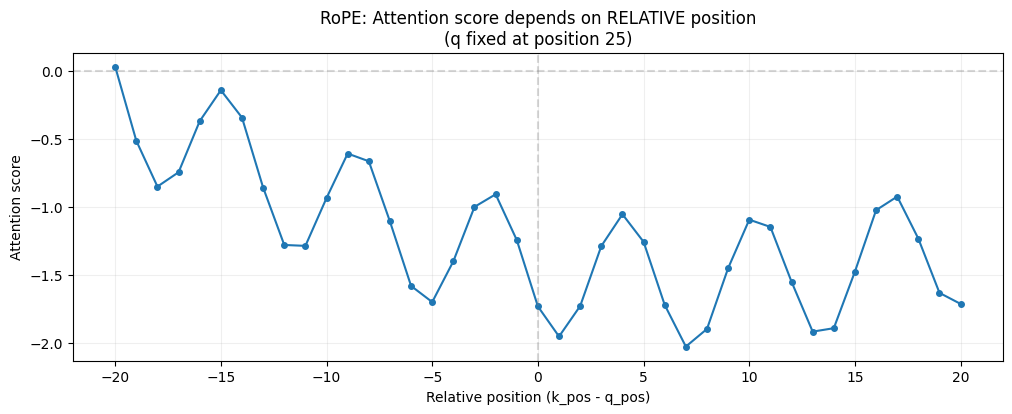

Notice: The score varies smoothly with relative distance.


In [362]:
# | rope-attention-curve inline
# Visualize how RoPE attention score varies with relative position
q = example_tensor[0].numpy() # assume this is post projection
k = example_tensor[1].numpy() # assume this is post projection

# Fix q at position 25, vary k's position
q_pos = 25
relative_positions = np.arange(-20, 21)
scores = []

for rel_pos in relative_positions:
    k_pos = q_pos + rel_pos
    q_rope = apply_rope(q, position=q_pos, d_model=6)
    k_rope = apply_rope(k, position=k_pos, d_model=6)
    scores.append(np.dot(q_rope, k_rope))

plt.figure(figsize=(12, 4))
plt.plot(relative_positions, scores, 'o-', markersize=4)
plt.xlabel('Relative position (k_pos - q_pos)')
plt.ylabel('Attention score')
plt.title('RoPE: Attention score depends on RELATIVE position\n(q fixed at position 25)')
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.3)
plt.grid(True, alpha=0.2)
plt.show()

print("Notice: The score varies smoothly with relative distance.")


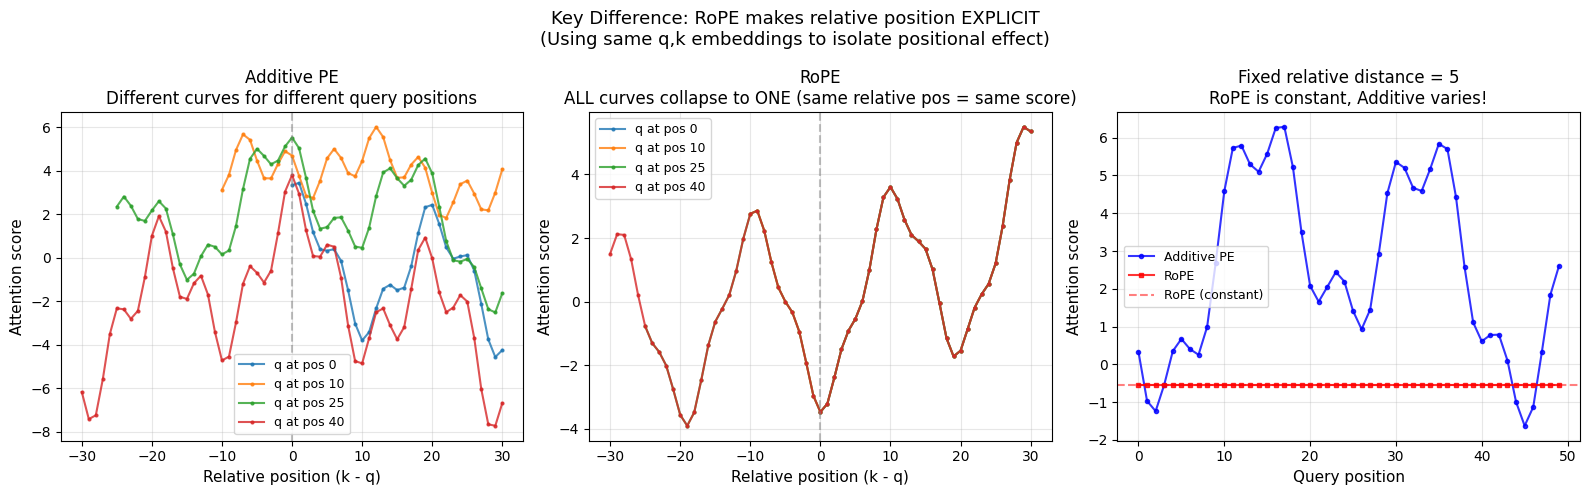

Left:   Additive PE — curves differ based on WHERE in the sequence
Middle: RoPE — ALL curves are identical (only relative position matters)
Right:  Same relative distance (5) — RoPE gives constant score, Additive varies


In [ ]:
# | rope-comparison-isolated inline
# Better comparison: Use SAME embeddings to isolate the positional effect
# This shows how position encoding affects attention independent of content

d_model = 16

# Use the SAME q and k embedding for all positions
# This isolates the effect of position encoding
q_base = np.random.randn(d_model)
k_base = np.random.randn(d_model)

pe = positional_encoding(100, d_model)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Plot 1: Additive PE - score vs relative position for different query positions
ax1 = axes[0]
query_positions = [0, 10, 25, 40]
relative_range = range(-30, 31)

for q_pos in query_positions:
    scores = []
    for rel in relative_range:
        k_pos = q_pos + rel
        if 0 <= k_pos < 100:
            q_add = q_base + pe[q_pos]
            k_add = k_base + pe[k_pos]
            scores.append(np.dot(q_add, k_add))
        else:
            scores.append(np.nan)
    ax1.plot(relative_range, scores, 'o-', markersize=2, alpha=0.8, label=f'q at pos {q_pos}')

ax1.set_xlabel('Relative position (k - q)', fontsize=11)
ax1.set_ylabel('Attention score', fontsize=11)
ax1.set_title('Additive PE\nDifferent curves for different query positions', fontsize=12)
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)
ax1.axvline(x=0, color='gray', linestyle='--', alpha=0.5)

# Plot 2: RoPE - score vs relative position for different query positions
ax2 = axes[1]

for q_pos in query_positions:
    scores = []
    for rel in relative_range:
        k_pos = q_pos + rel
        if 0 <= k_pos < 100:
            q_rope = apply_rope(q_base, position=q_pos, d_model=d_model)
            k_rope = apply_rope(k_base, position=k_pos, d_model=d_model)
            scores.append(np.dot(q_rope, k_rope))
        else:
            scores.append(np.nan)
    ax2.plot(relative_range, scores, 'o-', markersize=2, alpha=0.8, label=f'q at pos {q_pos}')

ax2.set_xlabel('Relative position (k - q)', fontsize=11)
ax2.set_ylabel('Attention score', fontsize=11)
ax2.set_title('RoPE\nALL curves collapse to ONE (same relative pos = same score)', fontsize=12)
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)
ax2.axvline(x=0, color='gray', linestyle='--', alpha=0.5)

# Plot 3: Direct comparison at relative position = 5
ax3 = axes[2]

add_scores_at_rel5 = []
rope_scores_at_rel5 = []
positions = range(0, 50)

for q_pos in positions:
    k_pos = q_pos + 5
    
    # Additive
    q_add = q_base + pe[q_pos]
    k_add = k_base + pe[k_pos]
    add_scores_at_rel5.append(np.dot(q_add, k_add))
    
    # RoPE
    q_rope = apply_rope(q_base, position=q_pos, d_model=d_model)
    k_rope = apply_rope(k_base, position=k_pos, d_model=d_model)
    rope_scores_at_rel5.append(np.dot(q_rope, k_rope))

ax3.plot(positions, add_scores_at_rel5, 'o-', markersize=3, alpha=0.8, label='Additive PE', color='blue')
ax3.plot(positions, rope_scores_at_rel5, 's-', markersize=3, alpha=0.8, label='RoPE', color='red')
ax3.axhline(y=rope_scores_at_rel5[0], color='red', linestyle='--', alpha=0.5, label='RoPE (constant)')

ax3.set_xlabel('Query position', fontsize=11)
ax3.set_ylabel('Attention score', fontsize=11)
ax3.set_title('Fixed relative distance = 5\nRoPE is constant, Additive varies!', fontsize=12)
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)

plt.suptitle('Key Difference: RoPE makes relative position EXPLICIT\n(Using same q,k embeddings to isolate positional effect)', fontsize=13)
plt.tight_layout()
plt.show()

print("Left:   Additive PE — curves differ based on WHERE in the sequence")
print("Middle: RoPE — ALL curves are identical (only relative position matters)")
print("Right:  Same relative distance (5) — RoPE gives constant score, Additive varies")

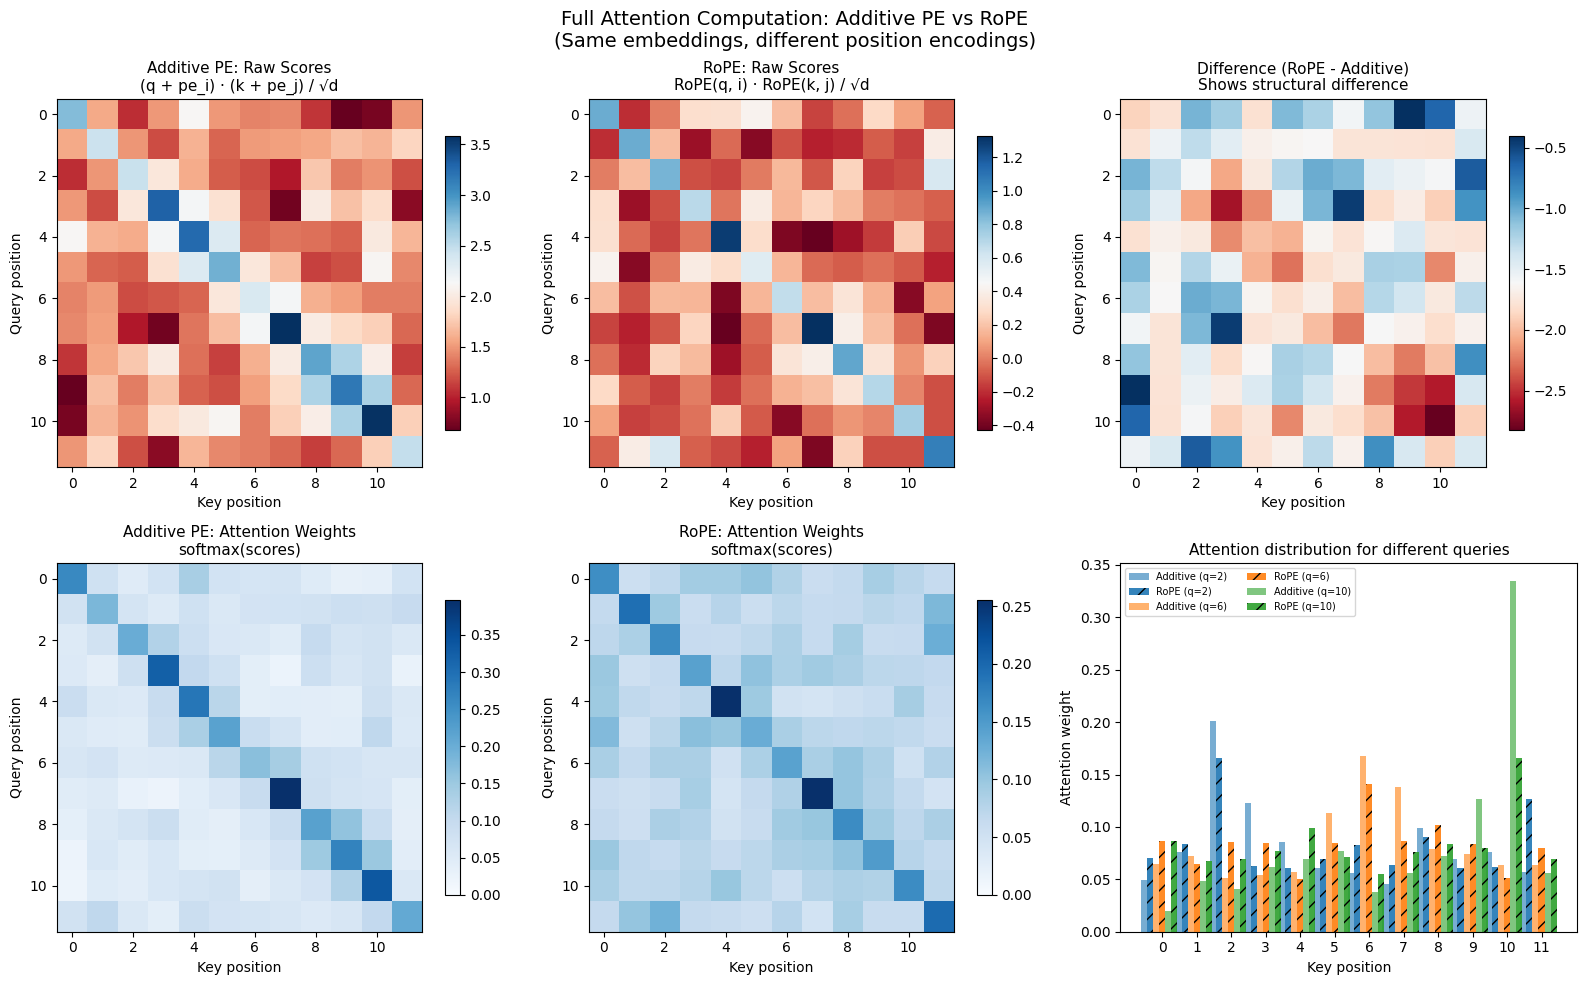

Top row: Raw attention scores (before softmax)
Bottom row: Attention weights (after softmax)

Both methods produce similar attention patterns, but RoPE encodes
relative position more explicitly in the computation.


In [ ]:
# | full-attention-comparison inline
# Visualization of full attention computation: Additive PE vs RoPE
seq_len = 12
d_model = 16

# Create some embeddings for our sequence
embeddings = np.random.randn(seq_len, d_model) * 0.5

pe = positional_encoding(seq_len, d_model)

# Compute attention scores (pre-softmax)
scores_add = np.zeros((seq_len, seq_len))
scores_rope = np.zeros((seq_len, seq_len))

for i in range(seq_len):
    for j in range(seq_len):
        # Additive PE
        qi_add = embeddings[i] + pe[i]
        kj_add = embeddings[j] + pe[j]
        scores_add[i, j] = np.dot(qi_add, kj_add) / np.sqrt(d_model)
        
        # RoPE
        qi_rope = apply_rope(embeddings[i], position=i, d_model=d_model)
        kj_rope = apply_rope(embeddings[j], position=j, d_model=d_model)
        scores_rope[i, j] = np.dot(qi_rope, kj_rope) / np.sqrt(d_model)

# Apply softmax to get attention weights
def softmax(x, axis=-1):
    exp_x = np.exp(x - np.max(x, axis=axis, keepdims=True))
    return exp_x / np.sum(exp_x, axis=axis, keepdims=True)

attn_add = softmax(scores_add, axis=1)
attn_rope = softmax(scores_rope, axis=1)

# Create comprehensive visualization
fig = plt.figure(figsize=(16, 10))

# Row 1: Raw attention scores
ax1 = fig.add_subplot(2, 3, 1)
im1 = ax1.imshow(scores_add, cmap='RdBu', aspect='auto')
ax1.set_xlabel('Key position')
ax1.set_ylabel('Query position')
ax1.set_title('Additive PE: Raw Scores\n(q + pe_i) · (k + pe_j) / √d', fontsize=11)
plt.colorbar(im1, ax=ax1, shrink=0.8)

ax2 = fig.add_subplot(2, 3, 2)
im2 = ax2.imshow(scores_rope, cmap='RdBu', aspect='auto')
ax2.set_xlabel('Key position')
ax2.set_ylabel('Query position')
ax2.set_title('RoPE: Raw Scores\nRoPE(q, i) · RoPE(k, j) / √d', fontsize=11)
plt.colorbar(im2, ax=ax2, shrink=0.8)

# Row 1, Col 3: Difference in raw scores
ax3 = fig.add_subplot(2, 3, 3)
diff = scores_rope - scores_add
im3 = ax3.imshow(diff, cmap='RdBu', aspect='auto')
ax3.set_xlabel('Key position')
ax3.set_ylabel('Query position')
ax3.set_title('Difference (RoPE - Additive)\nShows structural difference', fontsize=11)
plt.colorbar(im3, ax=ax3, shrink=0.8)

# Row 2: After softmax (actual attention weights)
ax4 = fig.add_subplot(2, 3, 4)
im4 = ax4.imshow(attn_add, cmap='Blues', aspect='auto', vmin=0)
ax4.set_xlabel('Key position')
ax4.set_ylabel('Query position')
ax4.set_title('Additive PE: Attention Weights\nsoftmax(scores)', fontsize=11)
plt.colorbar(im4, ax=ax4, shrink=0.8)

ax5 = fig.add_subplot(2, 3, 5)
im5 = ax5.imshow(attn_rope, cmap='Blues', aspect='auto', vmin=0)
ax5.set_xlabel('Key position')
ax5.set_ylabel('Query position')
ax5.set_title('RoPE: Attention Weights\nsoftmax(scores)', fontsize=11)
plt.colorbar(im5, ax=ax5, shrink=0.8)

# Row 2, Col 3: Show attention for specific queries
ax6 = fig.add_subplot(2, 3, 6)
query_positions = [2, 6, 10]
x = np.arange(seq_len)
width = 0.35

for idx, q_pos in enumerate(query_positions):
    offset = (idx - 1) * width
    ax6.bar(x + offset - width/2, attn_add[q_pos], width/2, alpha=0.6, 
            label=f'Additive (q={q_pos})', color=f'C{idx}')
    ax6.bar(x + offset, attn_rope[q_pos], width/2, alpha=0.9, 
            label=f'RoPE (q={q_pos})', color=f'C{idx}', hatch='//')

ax6.set_xlabel('Key position')
ax6.set_ylabel('Attention weight')
ax6.set_title('Attention distribution for different queries', fontsize=11)
ax6.legend(fontsize=7, ncol=2)
ax6.set_xticks(x)

plt.suptitle('Full Attention Computation: Additive PE vs RoPE\n(Same embeddings, different position encodings)', fontsize=14)
plt.tight_layout()
plt.show()

print("Top row: Raw attention scores (before softmax)")
print("Bottom row: Attention weights (after softmax)")
print("\nBoth methods produce similar attention patterns, but RoPE encodes")
print("relative position more explicitly in the computation.")

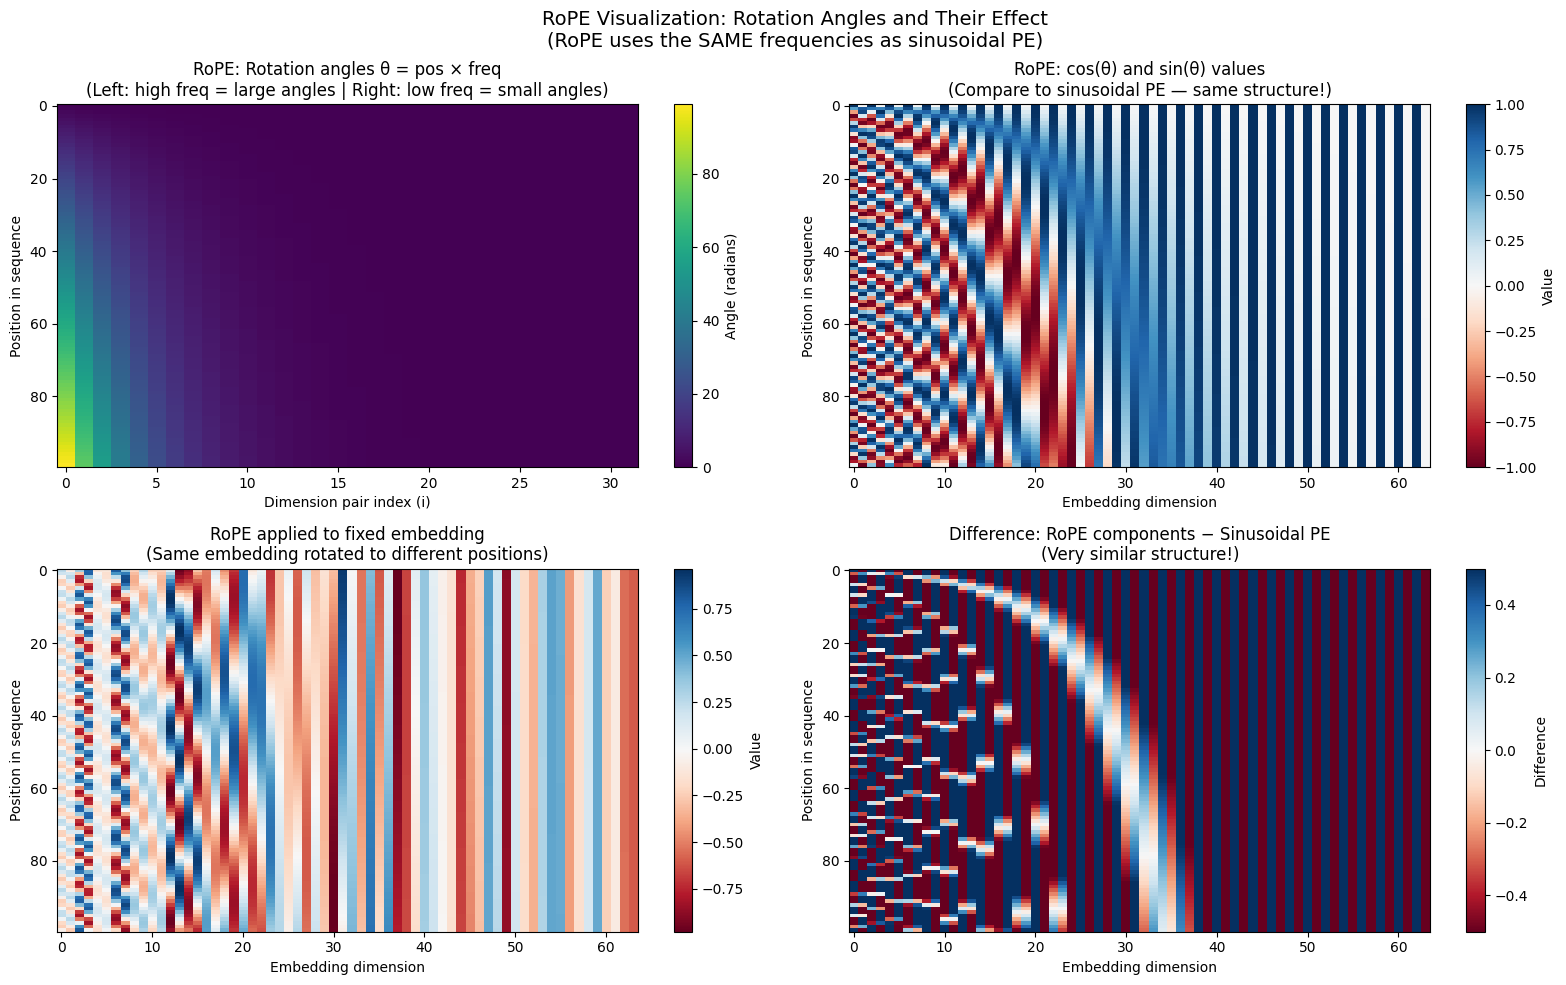

Top-left:  Rotation angles grow with position (faster for high-freq dimensions)
Top-right: cos(θ) and sin(θ) — looks just like sinusoidal PE!
Bot-left:  Same embedding rotated to 100 positions — creates unique representations
Bot-right: RoPE and sinusoidal PE use nearly identical cos/sin structure


In [351]:
# | rope-rotation-viz inline
# Visualize RoPE: Show rotation angles and effect on embeddings
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

max_len = 100
d_model = 64

# Top left: Rotation angles (θ = pos × freq) for each dimension pair
angles = np.zeros((max_len, d_model // 2))
for pos in range(max_len):
    for i in range(d_model // 2):
        freq = 1.0 / (10000 ** (2 * i / d_model))
        angles[pos, i] = pos * freq

ax1 = axes[0, 0]
im1 = ax1.imshow(angles, aspect='auto', cmap='viridis')
ax1.set_xlabel('Dimension pair index (i)')
ax1.set_ylabel('Position in sequence')
ax1.set_title('RoPE: Rotation angles θ = pos × freq\n(Left: high freq = large angles | Right: low freq = small angles)')
plt.colorbar(im1, ax=ax1, label='Angle (radians)')

# Top right: Cos and Sin of angles (what's actually used in rotation)
cos_angles = np.cos(angles)
sin_angles = np.sin(angles)

# Interleave to match sinusoidal PE format
rope_components = np.zeros((max_len, d_model))
rope_components[:, 0::2] = cos_angles
rope_components[:, 1::2] = sin_angles

ax2 = axes[0, 1]
im2 = ax2.imshow(rope_components, aspect='auto', cmap='RdBu', vmin=-1, vmax=1)
ax2.set_xlabel('Embedding dimension')
ax2.set_ylabel('Position in sequence')
ax2.set_title('RoPE: cos(θ) and sin(θ) values\n(Compare to sinusoidal PE — same structure!)')
plt.colorbar(im2, ax=ax2, label='Value')

# Bottom left: Apply RoPE to a fixed embedding, show the result
np.random.seed(42)
fixed_embedding = np.random.randn(d_model) * 0.5

rope_embeddings = np.zeros((max_len, d_model))
for pos in range(max_len):
    rope_embeddings[pos] = apply_rope(fixed_embedding, position=pos, d_model=d_model)

ax3 = axes[1, 0]
im3 = ax3.imshow(rope_embeddings, aspect='auto', cmap='RdBu')
ax3.set_xlabel('Embedding dimension')
ax3.set_ylabel('Position in sequence')
ax3.set_title('RoPE applied to fixed embedding\n(Same embedding rotated to different positions)')
plt.colorbar(im3, ax=ax3, label='Value')

# Bottom right: Compare sinusoidal PE vs RoPE components
ax4 = axes[1, 1]
pe_sinusoidal = positional_encoding(max_len, d_model)

# Show difference
diff = rope_components - pe_sinusoidal
im4 = ax4.imshow(diff, aspect='auto', cmap='RdBu', vmin=-0.5, vmax=0.5)
ax4.set_xlabel('Embedding dimension')
ax4.set_ylabel('Position in sequence')
ax4.set_title('Difference: RoPE components − Sinusoidal PE\n(Very similar structure!)')
plt.colorbar(im4, ax=ax4, label='Difference')

plt.suptitle('RoPE Visualization: Rotation Angles and Their Effect\n(RoPE uses the SAME frequencies as sinusoidal PE)', fontsize=14)
plt.tight_layout()
plt.show()

print("Top-left:  Rotation angles grow with position (faster for high-freq dimensions)")
print("Top-right: cos(θ) and sin(θ) — looks just like sinusoidal PE!")
print("Bot-left:  Same embedding rotated to 100 positions — creates unique representations")
print("Bot-right: RoPE and sinusoidal PE use nearly identical cos/sin structure")

### Verifying RoPE Satisfies Our Requirements

Let's check that RoPE still meets all the requirements we established earlier:

In [352]:
# | rope-verify-bounded inline
# Test RoPE on longer sequences
d_model = 64
test_embedding = np.random.randn(d_model)

# 1. Bounded values (via magnitude preservation)
print("1. BOUNDED VALUES (magnitude preserved)")
magnitudes = []
for pos in [0, 100, 1000, 10000]:
    rotated = apply_rope(test_embedding, position=pos, d_model=d_model)
    magnitudes.append(np.linalg.norm(rotated))
    
print(f"   Original magnitude: {np.linalg.norm(test_embedding):.6f}")
print(f"   At position 0:      {magnitudes[0]:.6f}")
print(f"   At position 100:    {magnitudes[1]:.6f}")
print(f"   At position 1000:   {magnitudes[2]:.6f}")
print(f"   At position 10000:  {magnitudes[3]:.6f}")
print(f"   → Magnitude preserved regardless of position ✓")

1. BOUNDED VALUES (magnitude preserved)
   Original magnitude: 7.836967
   At position 0:      7.836967
   At position 100:    7.836967
   At position 1000:   7.836967
   At position 10000:  7.836967
   → Magnitude preserved regardless of position ✓


In [353]:
# | rope-verify-unique inline
# 2. Unique per position
print("2. UNIQUE ENCODINGS")
rope_0 = apply_rope(test_embedding, position=0, d_model=d_model)
rope_1 = apply_rope(test_embedding, position=1, d_model=d_model)
rope_6 = apply_rope(test_embedding, position=6, d_model=d_model)
rope_100 = apply_rope(test_embedding, position=100, d_model=d_model)

print(f"   Distance pos 0 vs pos 1:   {np.linalg.norm(rope_0 - rope_1):.4f}")
print(f"   Distance pos 0 vs pos 6:   {np.linalg.norm(rope_0 - rope_6):.4f}")
print(f"   Distance pos 0 vs pos 100: {np.linalg.norm(rope_0 - rope_100):.4f}")
print(f"   → Different positions give different embeddings ✓")

# 3. Smoothness
print("\n3. SMOOTHNESS")
adjacent_dists = []
for pos in range(100):
    r1 = apply_rope(test_embedding, position=pos, d_model=d_model)
    r2 = apply_rope(test_embedding, position=pos+1, d_model=d_model)
    adjacent_dists.append(np.linalg.norm(r1 - r2))
    
far_dists = []
for pos in range(100):
    r1 = apply_rope(test_embedding, position=pos, d_model=d_model)
    r2 = apply_rope(test_embedding, position=pos+50, d_model=d_model)
    far_dists.append(np.linalg.norm(r1 - r2))

print(f"   Avg distance between adjacent positions: {np.mean(adjacent_dists):.4f}")
print(f"   Avg distance between positions 50 apart: {np.mean(far_dists):.4f}")
print(f"   → Nearby positions are more similar ✓")

# 4. Consistent meaning
print("\n4. CONSISTENT MEANING")
print(f"   RoPE doesn't depend on sequence length — same rotation for same position ✓")

# 5. Learnable relationships (relative position)
print("\n5. RELATIVE POSITION IS EXPLICIT")
print(f"   The dot product depends only on (pos_i - pos_j) ✓")


2. UNIQUE ENCODINGS
   Distance pos 0 vs pos 1:   2.0511
   Distance pos 0 vs pos 6:   6.0411
   Distance pos 0 vs pos 100: 6.4090
   → Different positions give different embeddings ✓

3. SMOOTHNESS
   Avg distance between adjacent positions: 2.0511
   Avg distance between positions 50 apart: 6.6657
   → Nearby positions are more similar ✓

4. CONSISTENT MEANING
   RoPE doesn't depend on sequence length — same rotation for same position ✓

5. RELATIVE POSITION IS EXPLICIT
   The dot product depends only on (pos_i - pos_j) ✓


### RoPE Implementation in PyTorch

Here's a more efficient implementation using PyTorch, similar to what's used in practice:

In [364]:
# | rope-pytorch inline
def precompute_freqs(d_model: int, max_len: int, base: float = 10000.0):
    """Precompute the frequency tensor for RoPE."""
    # Same frequency formula as sinusoidal PE
    freqs = 1.0 / (base ** (torch.arange(0, d_model, 2).float() / d_model))
    
    # Create position indices
    positions = torch.arange(max_len)
    
    # Outer product: (max_len,) x (d_model/2,) -> (max_len, d_model/2)
    angles = torch.outer(positions, freqs)
    
    return angles

def apply_rope_torch(x: torch.Tensor, angles: torch.Tensor) -> torch.Tensor:
    """
    Apply RoPE to a tensor.
    
    Args:
        x: tensor of shape (seq_len, d_model)
        angles: precomputed angles of shape (seq_len, d_model/2)
    
    Returns:
        rotated tensor of same shape
    """
    # Split into pairs
    x_pairs = x.view(x.shape[0], -1, 2)  # (seq_len, d_model/2, 2)
    
    # Get cos and sin
    cos = torch.cos(angles).unsqueeze(-1)  # (seq_len, d_model/2, 1)
    sin = torch.sin(angles).unsqueeze(-1)  # (seq_len, d_model/2, 1)
    
    # Apply rotation: [x, y] -> [x*cos - y*sin, x*sin + y*cos]
    x_rot = torch.cat([
        x_pairs[..., 0:1] * cos - x_pairs[..., 1:2] * sin,
        x_pairs[..., 0:1] * sin + x_pairs[..., 1:2] * cos
    ], dim=-1)
    
    return x_rot.view(x.shape)

# Test it
d_model = 6
max_len = 10
angles = precompute_freqs(d_model, max_len)

# Apply to our example tensor
x = example_tensor.clone()
x_rope = apply_rope_torch(x, angles[:3])

print("PyTorch RoPE implementation:")
print(f"Original shape: {x.shape}")
print(f"After RoPE:     {x_rope.shape}")
print()
print("Original Q projection 'The':", x[0].numpy().round(3))
print("After RoPE:    ", x_rope[0].numpy().round(3))
print()
print("Original Q projection 'cat':", x[1].numpy().round(3))
print("After RoPE:    ", x_rope[1].numpy().round(3))
print()
print("Original Q projection 'sat':", x[2].numpy().round(3))
print("After RoPE:    ", x_rope[2].numpy().round(3))


PyTorch RoPE implementation:
Original shape: torch.Size([3, 6])
After RoPE:     torch.Size([3, 6])

Original Q projection 'The': [ 0.601  0.109  1.253 -0.69   0.239  1.337]
After RoPE:     [ 0.601  0.109  1.253 -0.69   0.239  1.337]

Original Q projection 'cat': [-0.573  0.537 -0.891  0.986 -0.319  0.321]
After RoPE:     [-0.761 -0.192 -0.935  0.944 -0.32   0.32 ]

Original Q projection 'sat': [-0.197 -0.777 -1.466 -1.087  0.347  0.957]
After RoPE:     [ 0.788  0.144 -1.359 -1.218  0.343  0.959]


In [ ]:
# we want to repeat the positional embedding for each token in the batch
# the way that we do this is by having token 2i and 2i + 1 as sin and cos
# i is the dim of the embedding (for 768, i ranges from 0 to 767)
# position is the position in the sequence (for 1024, it ranges from 0 to 1023)
# d is the dimension of the model (same as embedding dim)
# we also want to repeat this for each batch
        
class SinusoidalPosEmbed(nn.Module):
    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg

        d = cfg.d_model   # Dimensionality of model embeddings
        n = cfg.n_ctx     # Maximum sequence length

        # Create a column vector for positions (shape: [n, 1])
        position = torch.arange(n).unsqueeze(1)

        # Calculate frequency scaling term for each pair of dimensions (shape: [d/2])
        # Each pair (2i, 2i+1) will get the same frequency
        div_term = torch.exp(torch.arange(0, d, 2) * (-math.log(10000.0) / d))

        # Initialize positional embedding matrix (shape: [n, d]) to zeros
        pe = torch.zeros(n, d)

        # Fill even dimensions (0, 2, 4, ...) with sinusoids of different frequencies
        pe[:, 0::2] = torch.sin(position * div_term)
        # Fill odd dimensions (1, 3, 5, ...) with cosines of different frequencies
        pe[:, 1::2] = torch.cos(position * div_term)

        # This line registers 'W_pos' as a buffer. Unlike a normal variable or parameter,
        # a buffer is a tensor that becomes part of the model's state: it gets moved with the model
        # to whatever device (CPU/GPU) the model itself is moved to, and is saved or loaded with state_dict,
        # but (unlike nn.Parameters) it is not trainable. PyTorch will not compute gradients or update it during training.
        self.register_buffer("W_pos", pe)

    def forward(self, tokens: Tensor):     # tokens shape: (batch, seq)
        # Unpack batch size and sequence length from input tokens
        batch, seq_len = tokens.shape
        # Return the positional embeddings for the required sequence length (shape: [seq_len, d])
        return self.W_pos[:seq_len]


In [ ]:
# | learned-embed-class
class LearnedPosEmbed(nn.Module):
    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg

        # Create a learnable positional embedding matrix of shape (n_ctx, d_model)
        # n_ctx: maximum sequence length, d_model: model embedding dimension
        # Each row corresponds to a position in the sequence, each column to an embedding dimension
        # The matrix is initialized from a normal distribution with standard deviation cfg.init_range
        self.W_pos = nn.Parameter(torch.randn(cfg.n_ctx, cfg.d_model) * cfg.init_range)

    def forward(self, tokens: Tensor):      # tokens shape: (batch, seq)
        batch, seq_len = tokens.shape
        # Retrieve positional embeddings for the required sequence length (first seq_len positions)
        # Shape returned: (seq_len, d_model)
        return self.W_pos[:seq_len]

In [ ]:
# | rope-class inline expanded
class RoPE(nn.Module):
    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        
        # RoPE operates on pairs of dimensions, so d_head must be even
        assert cfg.d_head % 2 == 0, "d_head must be even for RoPE"
        
        # Compute the rotation frequencies for each dimension pair
        # For dimension pair i (where i = 0, 1, 2, ..., d_head/2 - 1),
        # the frequency is: theta_i = 10000^(-2i/d_head)
        dim_indices = torch.arange(0, cfg.d_head, 2).float()
        freqs = 1.0 / (10000.0 ** (dim_indices / cfg.d_head))
        
        # Pre-compute position indices for maximum context length
        # Shape: (n_ctx, 1)
        positions = torch.arange(cfg.n_ctx).unsqueeze(1)
        
        # Compute all rotation angles: position * frequency
        # Shape: (n_ctx, d_head/2)
        angles = positions * freqs.unsqueeze(0)
        
        # Pre-compute cos and sin for all positions and dimensions
        # We'll use these to apply rotations efficiently
        # Shape: (n_ctx, d_head/2)
        cos_cached = torch.cos(angles)
        sin_cached = torch.sin(angles)
        
        # Register as buffers so they move with the model but aren't trainable
        self.register_buffer("cos_cached", cos_cached)
        self.register_buffer("sin_cached", sin_cached)
    
    def rotate_half(self, x: Tensor) -> Tensor:
        """
        Rearranges elements for rotation.
        Takes pairs of elements (x1, x2) and returns (-x2, x1).
        This is used to apply 2D rotation via element-wise operations.
        
        Input shape: (..., d_head) where d_head is even
        Output shape: same as input
        """
        # Split the last dimension into two halves
        x1, x2 = x.chunk(2, dim=-1)
        # Concatenate in rotated order: (-x2, x1)
        return torch.cat((-x2, x1), dim=-1)
    
    def apply_rotary_pos_emb(self, x: Tensor, seq_len: int) -> Tensor:
        """
        Apply rotary position embeddings to input tensor.
        
        Args:
            x: Input tensor of shape (batch, n_heads, seq_len, d_head) or (batch, seq_len, n_heads, d_head)
            seq_len: Length of the sequence
            
        Returns:
            Rotated tensor of the same shape as input
        """
        # Get cos and sin for the current sequence length
        # Shape: (seq_len, d_head/2); Each entry corresponds to a *frequency pair* (for dims 0/1, 2/3, ...)
        cos = self.cos_cached[:seq_len]   # (seq_len, d_head//2)
        sin = self.sin_cached[:seq_len]   # (seq_len, d_head//2)
        
        # Next: We want to rotate *each pair* of dimensions (0/1, 2/3, ...) by its own frequency
        # So we stack cos & sin so for (seq_len, d_head) where positions 0,1 get cos[:,0], 2,3 get cos[:,1], etc

        # Interleave cos and sin to align: [c0, c0, c1, c1, ...] along last dim
        cos = cos.repeat_interleave(2, dim=-1)  # (seq_len, d_head)
        sin = sin.repeat_interleave(2, dim=-1)  # (seq_len, d_head)
        # Now, for dim i (i even), both i and i+1 get their associated value.

        # For broadcasting: Move seq_len and d_head to right places for input x
        # If x has (batch, n_heads, seq_len, d_head):
        if x.dim() == 4 and x.shape[2] == seq_len:
            cos = cos[None, None, :, :]  # (1,1,seq_len,d_head)
            sin = sin[None, None, :, :]
        # If x has (batch, seq_len, n_heads, d_head):
        elif x.dim() == 4 and x.shape[1] == seq_len:
            cos = cos[None, :, None, :]  # (1,seq_len,1,d_head)
            sin = sin[None, :, None, :]

        # Yes, cos and sin come in as shape (seq_len, d_head//2), that's the *number of pairs*.
        # We repeat each freq twice so, e.g., cos[:, 0] applies to d=0,1, then cos[:,1] to d=2,3, etc:
        # - for d in [0, 2, 4,..., d_head-2] —> cos[:, d//2] for both d and d+1.
        # This means, over d=0..d_head-1, the values are interleaved: [f0, f0, f1, f1, ...]
        #
        # When we do:
        x_rotated = (x * cos) + (self.rotate_half(x) * sin)
        # each "pair" (x[..., 2i], x[..., 2i+1]) is mapped via the same frequency, forming a 2D rotation:
        #   [x1', x2'] = [ x1 * cos - x2 * sin,  x2 * cos + x1 * sin ]
        # (Here, self.rotate_half swaps x1 <-> x2 and negates x2).
        #
        # So yes, this covers the x//2 (that's "number of pairs"), and the expanded cos/sin interleave
        # through to x.size(-1) with this broadcasted pattern.
        
        return x_rotated
    
    def forward(self, q: Tensor, k: Tensor) -> tuple[Tensor, Tensor]:
        """
        Apply RoPE to query and key tensors.
        
        Args:
            q: Query tensor of shape (batch, n_heads, seq_len, d_head) or (batch, seq_len, n_heads, d_head)
            k: Key tensor of same shape as q
            
        Returns:
            Tuple of (rotated_q, rotated_k) with same shapes as inputs
        """
        # Determine sequence length from the shape
        seq_len = q.shape[2] if q.shape[2] <= self.cfg.n_ctx else q.shape[1]
        
        # Apply rotary embeddings to both q and k
        q_rotated = self.apply_rotary_pos_emb(q, seq_len)
        k_rotated = self.apply_rotary_pos_emb(k, seq_len)
        
        return q_rotated, k_rotated

## Summary: RoPE vs Sinusoidal PE

| Aspect | Sinusoidal PE | RoPE |
|--------|--------------|------|
| **How applied** | Added to embedding | Rotation of Q, K |
| **Dimension** | Same | Same |
| **Frequency formula** | Same (10000 base) | Same (10000 base) |
| **Sin/cos usage** | Added as values | Used for rotation matrix |
| **Relative position** | Implicit (in dot product) | Explicit (rotation difference) |
| **Magnitude** | Changes (adds values) | Preserved (rotation) |

**Key insight**: RoPE takes the same mathematical foundation (sin/cos at multiple frequencies) but applies it as **rotation** instead of **addition**. This makes relative position explicit while keeping the same useful properties.

## The Journey: From Problem to RoPE

Let's trace how we got here:

1. **Problem**: Transformers are permutation-invariant — they need position information
2. **First attempts**: Integers (scale explosion), normalization (scale variance) ✗
3. **Sine function**: Bounded and smooth ✓, but repeats ✗
4. **Multiple frequencies**: High freq for local, low freq for global ✓
5. **Adding cosine**: Disambiguates positions that have same sine value ✓
6. **The 10000 base**: Geometric frequency progression for long contexts ✓
7. **Sinusoidal PE works!** But position is "mixed in" via addition...
8. **RoPE insight**: (sin, cos) pairs = rotation! Apply position as rotation instead of addition
9. **Result**: Relative position becomes **explicit** in the dot product ✓

Each step solved a specific problem, building on the intuitions from before. RoPE isn't a completely new idea — it's a clever reframing of the same sin/cos foundation we already understood.

---

**RoPE is now the standard in modern LLMs** (LLaMA, Mistral, etc.) because:
- It makes relative position explicit (cleaner signal for the model)
- It preserves embedding magnitude (numerically stable)
- It uses the same frequency formula that already worked well
- It's computationally efficient (can be fused with attention)

The lesson: sometimes the best innovations come from looking at familiar tools from a new angle! 🎉